# Predict Electric Rotor Temperature

Student information
- Family Name: Kim
- Given Name: Dahye
- Student ID: 31356508
- Student email: dkim0017@student.monash.edu

Programming Language: R 3.6.1 in Jupyter Notebook

R Libraries used:
- readr
- ggplot2
- reshape2
- caret


## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_2)
3. [Methodology & Model Development](#sec_3)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)
3. [References](#sec_8)

# 1. Introduction <a class="anchor" id="sec_1"></a>

This program creates series of machine learning models to predict electric motor temperature using various features, including the electric current and voltages, temperature of the ambient and ambient. It first starts off by loading in the data and explore the structure of the data set. Then an extensive exploratory data analysis is performed to inspect the distribution of each attribute in the data set, as well as relationship between each variable pairs. After the EDA, the training data set is fit into numbers of non-parametric and parametric regression models in order to predict the electric rotor temperature. For non-parametric model, necessary hyperparmetres are optimised using cross validation methods. For parametric models, apt parameter estimation assumptions are checked before training the parametric models. The assessment of performance of each model is conducted using cross validations. Finally, the test data set is applied to all the pre-trained models for predicting the target. Some interpretations of the training process and test results are included. 

## 1. Loading the Data

The following chunk of code loads in the data set and divide the entire data set into train and test sets. The test set is composed of the observations with ``profile_id == 72, 81``. For prediction and inference tasks, we I removed all attributes that are not necessary, including ``stator_yoke``,``stator_tooth``,``stator_winding``, and `profile_id`. 

In [1]:
rm(list = ls())
library(readr)

# unnecessary attributes for the tasks 
unrrelated<- c('stator_yoke','stator_tooth','stator_winding') 

# read in the entire data set, exclude unrrelated attributes 
temp <- read.csv('pmsm_temperature_data_A1_2021.csv')
temp <- temp[,!names(temp)%in%unrrelated]

# test set is composed of observation with profile_id of 72 and 81 
test <- temp[temp$profile_id %in% c(72, 81), names(temp)!='profile_id']
# train set is the rest of the obsevations 
train <- temp[!temp$profile_id %in% c(72, 81), names(temp)!='profile_id']
# profile_id attribute is removed since they are not necessary for the prediction/inferecne 

# 2. Exploratory Data Analysis<a class="anchor" id="sec_2"></a>

The EDA section starts with a brief look into the data structure of the train data set. The EDA is then divided into two parts: 

* [Exploring Statistical Characteristics of Each Variable](#sec_2.1)
    * This section explores statistical characteristics of each attribute in the data set. This includes each atttribute's the statistical summary, normality, and its distribution using various visualisation methods 
    
    
* [Exploring the Relationship between Each Variables](#sec_2.2)
    * After grasping the statistical characteristics of each attribute, this section explores the relationship between each and every variable in the train data set. The focus is mainly on their linear relationships using correlation matrix and scatter plots. 

In [2]:
str(train)

'data.frame':	9652 obs. of  9 variables:
 $ ambient    : num  0.118 -0.555 -0.772 0.22 0.402 ...
 $ coolant    : num  -1.04 -1.09 -1.06 -1.08 -1.08 ...
 $ u_d        : num  -1.027 -1.226 0.299 -1.026 0.316 ...
 $ u_q        : num  0.925 0.513 0.956 0.928 -0.709 ...
 $ motor_speed: num  1.212 2.024 -0.14 1.212 -0.952 ...
 $ torque     : num  0.359 0.284 -0.259 0.357 -0.256 ...
 $ i_d        : num  -0.834 -1.364 1.029 -0.838 1.029 ...
 $ i_q        : num  0.323 0.234 -0.246 0.323 -0.246 ...
 $ pm         : num  -0.0883 0.7104 -1.5926 -0.1417 -1.9649 ...


The ``train`` data set is composed of $9652$ observations and $9$ different attributes. All attributes in the data set are continuous numerical variables. 
According to the original data set publisher, the attributes of the data set are as follow: 

* **Ambient**: ambient temperature measured by a thermal sensor located closely to the stater 
* **Coolant**: coolant temperature. The motor is water cooled, measurement is taken at outflow
* **u_d**: voltage d-component, result of a standard control strategy trying to follow the reference speed and torque 
* **u_q**: voltage q-component, result of a standard control strategy trying to follow the reference speed and torque 
* **i_d**: current d-component, result of a standard control strategy trying to follow the reference speed and torque 
* **i_q**: current q-component, result of a standard control strategy trying to follow the reference speed and torque 
* **Motor_speed**: motor speed 
* **torque**: torque induced by current 
* **pm**: permanent magnet surface temperature representing the rotor temperature. This is measured with an infrared thermography unit

Based on the description above, it is likely that ``u_d``, ``u_q``, ``i_d``, ``i_q`` are derived from ``motor_speed`` are ``torque``. This could indicate that the correlation or the distribution of the aforementioned variables could be similar to another.

## 2.1 Exploring Statistical Characteristics of Each Variable<a class="anchor" id="sec_2.1"></a>

In [3]:
sd <- sapply(train, sd)
mean <- sapply(train, mean)
median <- sapply(train, median)
qt.3rd <- sapply(train, quantile)['75%',]
qt.1st <- sapply(train, quantile)['25%',]
iqr <- qt.3rd - qt.1st
iqr.right <- qt.3rd + 1.5*iqr
iqr.left <- qt.1st - 1.5*iqr
maxi <- sapply(train, max)
min <- sapply(train, min)

In [4]:
data.frame(sd, min, iqr.left, qt.1st, median, mean, qt.3rd, iqr.right, maxi)

sd        min       iqr.left  qt.1st     median      mean        
ambient     1.0129625 -3.327762 -2.536838 -0.6019619  0.29472131  0.004568387
coolant     1.0020208 -1.237039 -3.516140 -1.0407029 -0.18514249 -0.009028253
u_d         1.0026041 -1.653711 -2.665113 -0.8507855  0.24569447 -0.009845283
u_q         0.9962388 -1.814612 -3.514948 -0.8877659 -0.09268637  0.008342602
motor_speed 0.9987153 -1.222439 -3.671090 -0.9518741 -0.14024412  0.012055425
torque      1.0093463 -3.316342 -1.525536 -0.2735244 -0.13640740  0.010129704
i_d         1.0020043 -3.176439 -3.424061 -0.7625217  0.15256268 -0.016238062
i_q         1.0086481 -3.308669 -1.460839 -0.2627274 -0.11693288  0.009498914
pm          1.0127933 -2.605213 -2.751970 -0.6718179  0.11505178  0.011171471
            qt.3rd    iqr.right maxi    
ambient     0.6879555 2.622832  2.710575
coolant     0.6095884 3.085025  2.278400
u_d         0.3587663 2.173094  2.273458
u_q         0.8636888 3.490871  1.770184
motor_speed 0.8609362 3.580152  2.024132
torque      0.5611502 1.813162  3.013790
i_d         1.0118375 3.673376  1.060168
i_q         0.5360136 1.734125  2.914178
pm          0.7149503 2.795103  2.905198

The data frame above displays all the statistical characteristics of each and every attribute. The standard deviation `sd` of all the attributes are close to 1, and the mean of all attributes are close to 0. This could indicate that the data set has already been scaled using standardised z-score transformation. 

A lot of attributes' medians are slightlhy deviating from the median. Attribute such as `ambient` has a median of 0.29 and the mean of 0.005, and `u_d` has a median of 0.25 and the mean of -0.010. Considering that the 50% quantile of the attribute is much larger than its central tendency, such attributes could be skewed to the left. Similarly, the attributes whose median is significantly smaller than the mean could also be skewed to the right. This could be further demonstrated by looking at the range and the IQR of each attribute. The data points outside of the IQRs on both sides are considered as possible outlier candidates. Features such as ``ambient``, ``torque``, and ``i_q`` have significantly smaller minimum than the IQR to the left. Since the median of `ambient` is larger than the mean, and the minimum is far smaller than the IQR, the distribution of this feature is likely to be skewed to the left. Similar characteristic is also observed on `motor_speed` and `i_d`. On the other hand, the maximum of `torque` and `i_q` are also larger than the IQR on the right. This could imply that the distribution of both features could be very spread out, with some fat tails to both side of the curve.

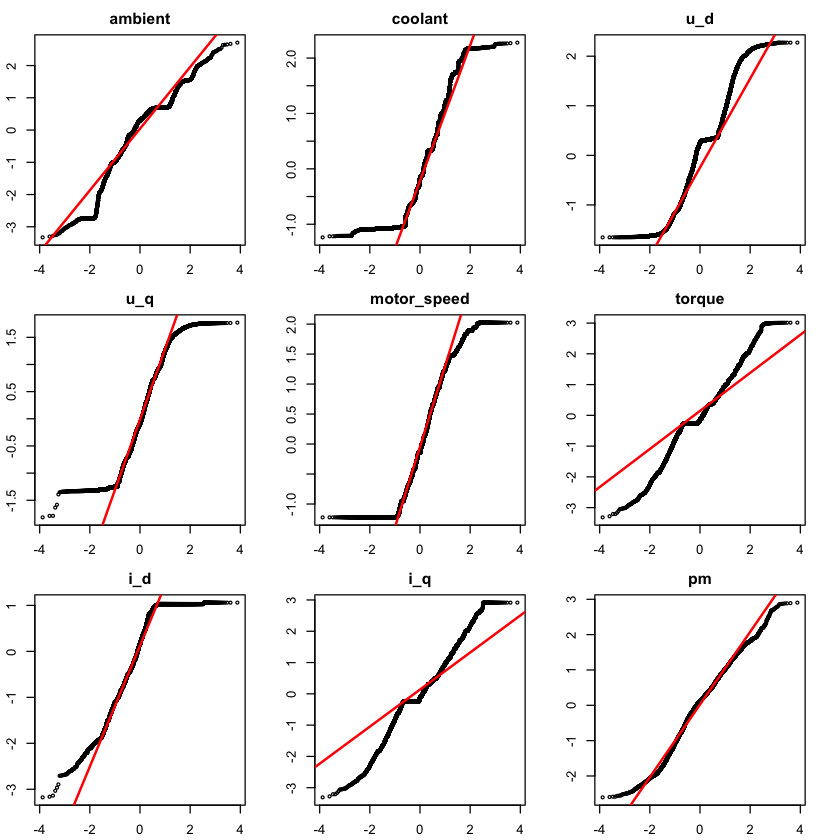

In [5]:
par(mar = rep(2.2,4), mfrow = c(3,3))
for (i in names(train)){
  qqnorm(train[, i], ylab = '', xlab = '', main = i, cex = 0.5)
  qqline(train[, i], ylab = '', col = 'red', lwd = 2)
}

To examine the normality of the features and target's distribution, I created QQplot for each variable from the train data set. The data points of an attribute with a normal or close to a normal distribution should align with the red diagonal line in the centre of the plot. In accordance to the plots above, only ``pm`` has a distribution close to Gaussian, but still with some outliers at the two ends of the curve. 

The QQplot of `ambient` is slightly deviated to the right side of the diagonal line. Such deviation to one side of the line indicates a skew - `ambient` could be skewed to the left.

``torque`` and ``i_q`` have a very similar distribution, and both attributes have outliers on both sides of the curve. This is indicated by the data points deviating to both side of the red diagonal line. This also aligns with the assumption I made when inspecting the statistical summaries of these features. 

``u_q``, ``motor_speed``, ``coolant``, and ``i_d``, on the other hand, all have extremely fat tails at the end of each curve. This could indicate that all four features have huge number of possible candidates for outliers, and it could also means that the variable is very densely concentrated at a specific value range in the centre. 

To explore the distribution of the variables further, I created histogram with density curves, as well as a normal curve fitted on the histogram. 

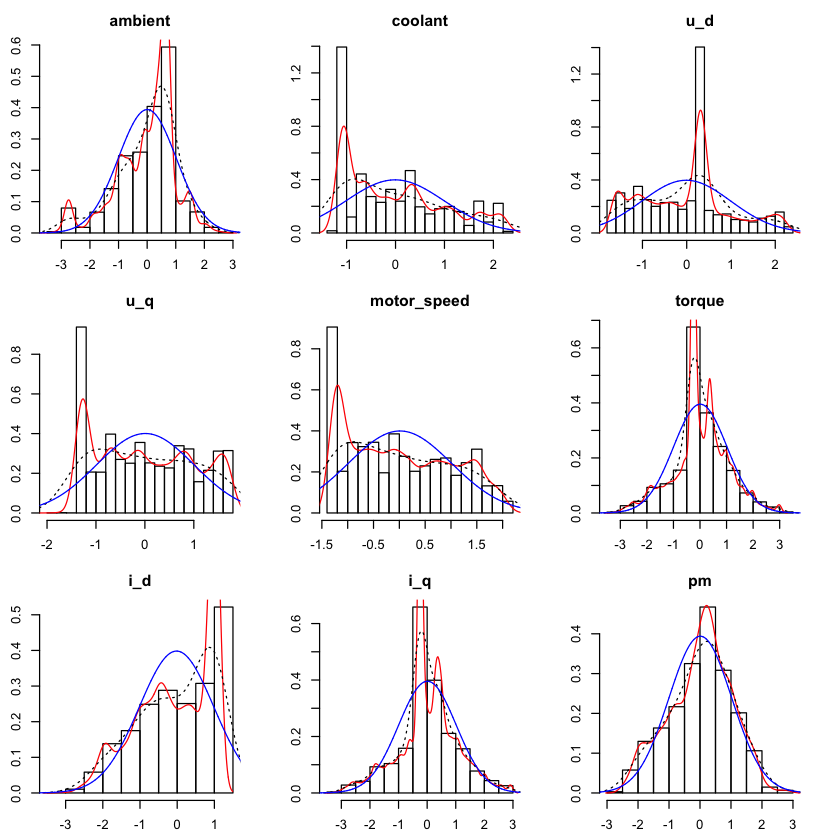

In [6]:
par(mar = rep(2.5,4), mfrow = c(3,3))
for (i in names(train)){
    
  hist(train[, i], prob = T, main = i, xlab = '', ylab = '')
    # histogram of each feature 
  lines(density(train[, i]), col = 'red')
    # density plot of each feature 
  lines(density(train[,i ], adjust = 3), col = 'black', lty = 'dotted')
    # smoothened density plot of each feature 
    
    m <- mean(train[,i])
    s <- sd(train[,i])
    sim <- dnorm(seq(-4,4, 0.001),m, s)
    # generate random set of numbers with the mean and standard deviation of each feature but with normal distribution
    lines(seq(-4,4, 0.001), sim, col = 'blue')
    # plot an ideal normal curve with the mean and sd of each feature 
}

For the curves overlaying the histogram, each curve represents the follow: 
* <font color="red">Red solid curve</font> - density of the variable 
* Black dotted curve - smoothened density of the variable 
* <font color="blue">Blue dotted curve</font> - ideal normal curve with the mean and standard deviation of the variable

The target variable, `pm`, has a distribution close to normal with a very slight left skew. This is demonstrated by the unimodal symmetrical histogram with even spread to both side. The smoothened density curve almost aligns with the blue normal curve. This shows that the target variable has a distribution close to Gaussian. 

The variable ``ambient`` and ``i_d`` are skewed to the left. `ambient` seems to have a very wide spread to both side of the curve, while `i_d` shows a skew to left side only. The peak of the density plot of both attributes are all more tilted to the right in comparison to the ideal normal curve. 

When inspecting the QQplot, we observed that `i_q` and `torque` have a very similar distribution. This is proven by the histogram and density curves of both attributes. Both attributes have a very wide spread to both sides. The density curve in red colour almost have the same shape from another, and even the centre and spread of the blue bell curve look identical.

``coolant``, ``u_q``, and ``motor_speed`` also display very similar distributions. Their histograms are all unimodal but with almost uniform spread outside of the mode. Their distributions all are skewed to the right.

``u_d``, on the other hand, is a unimodal distrbution that does not have a shape of Gaussian. Based on the density curve in red colour, we can see that the data points are all heavily dense at the range of $(0, 0.5)$; however, the ideal Gaussian curve in blue colour has a centre to the right. This indicates that the rest of the data points outside of the aforementioned range is slightly skewed to the right. Interestingly, the QQplot suggested that `u_q`'s histogram could be a symmetrical unimodal histogram with wider spread to two sides (similar to `torque`), but the actual histogram and density plots are displaying a contrary result. 

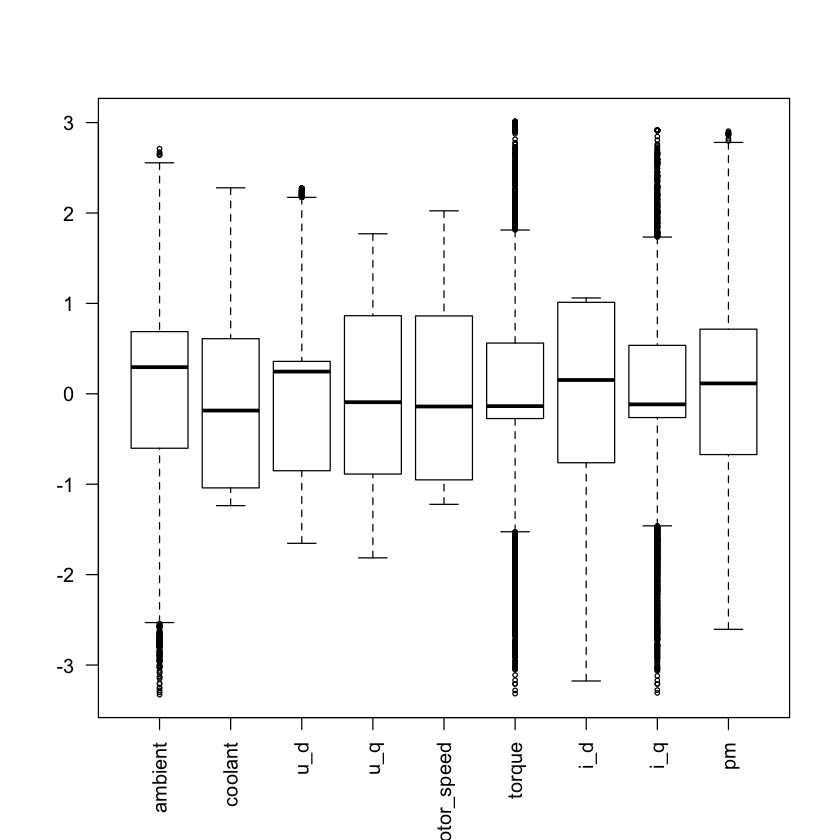

In [7]:
boxplot(train, las = 2, cex = 0.5)

As we have seen from the QQ-plot, ``torque`` and ``i_q`` have a lot of possible outlier candidates to both sides of the distribution based on the boxplots. The 1st and 3rd quantile of their boxplot are located between $[-0.2, 0.5]$, indicating that more 50% of the data points are concentrated between these range. 

Similar to what the QQplots suggested, `ambient` is skewed to the left with a lot of outlier candidates on both sides of the curve. The boxplot also suggests that `i_d` has a left-skewed distribution, with its 1st, 2nd, and 3rd quantiles deviating from the centre of the whiskers.

Based on the QQplot of `u_q`, its distribution seemed to follow a bell curve with fat tails on both sides. However, the density plot and the histogram suggested that this variable is skewed to the right. The boxplot, on the other hand, is suggesting that the `u_q` is following a normal distribution without any outlier candidates on either side of the curve. Such pattern was also observed from `motor_speed` and `coolant`, where the QQplot suggested a Gaussian curve with fat tails on both sides, but the histogram and the density plot displayed a right-skewed distribution. However, the boxplot of `motor_speed` and `coolant` is only showing a slightly right-skewed distribution without any outlier candidates. 

According to the boxplot, the target variable, `pm`, has a normal distribution with some outlier candidates on the right side of the curve. This aligns with the observation of QQplot, histogram, and density plot above. 

## 2.2 Exploring the Relationship between Each Variables<a class="anchor" id="sec_2.2"></a>

In [8]:
library(reshape2)
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


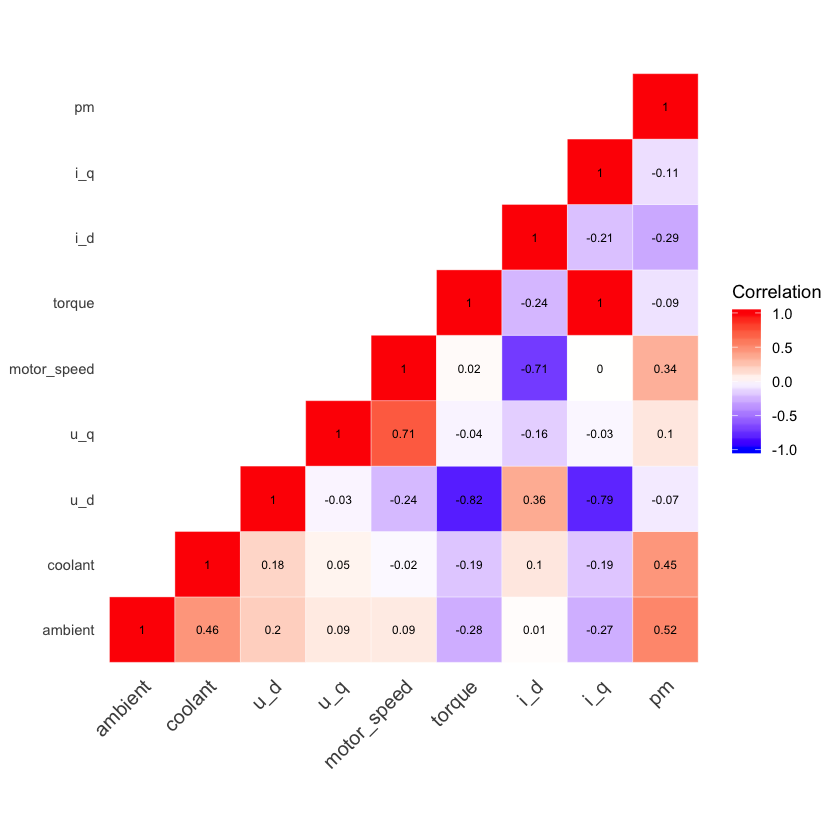

In [9]:
correlation <- cor(train)
# correlation matrix of all the featrues 
correlation[lower.tri(correlation)]<- NA
# lower triangle of the matrix to NA 
# the correlation matrix is diagonally symmetric
# removing repetitive correlations
correlation.lower <- melt(correlation, na.rm = T)

ggplot(data = correlation.lower, aes(Var2, Var1, fill = value))+
  geom_tile(color = 'white')+
  geom_text(aes(label = round(value,2)),color = 'black', size = 2.5)+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1),
    axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),)+
 coord_fixed()

# This chunk of code is adapted from 
# Ggplot2 : Quick Correlation Matrix Heatmap - R Software and Data Visualization - Easy Guides - Wiki - STHDA, n.d.
# http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization

In accordance to the correlation matrix, ``i_q`` and ``torque`` have a correlation of $1$. This means that these two variables have a perfect positive linear relationship with another - when ``i_q`` increases, ``torque`` also increases. Due to this perfect correlation between two variables, we can observe that the correlation between ``i_q`` and other variables are almost identical to that of ``torque`` and other variables: 
``i_q`` and ``torque`` both have a very strong positive correlation with ``u_d``, $-0.81$ and $-0.83$ respectively. Therefore, for a simple regression model, removing one of these variables should not impact the predictive performance of the model. 

On the other hand,  `motor_speed` and `i_d` have a very strong negative correlation of $-0.77$, where if one increases, another decreases. Oppositely, ``u_q`` and ``motor_speed`` are strongly but positively correlated to another with the correlation of $0.8$ - if `u_q` increases, `motor_speed` shows an increasing trend. Such close relationships between `i_d`, `torque`, `i_q`, `u_d`, `motor_speed` and `u_q` aligns with the assumption I made when reading through the description of the attributes at section 1.2. 

With the target variable `pm`, the features `ambient` and `coolant` are showing moderate and positive correlation, while `torque` and `i_d` are showing a weak correaltion. These four variables could be very important when predicting `pm` using linear models due to their linear relationship with `pm`. 

All other variable pairs in either light purple or orange colour are all showing very weak linear relationship with another. 

The correlation of two variables, however, are indicator to the strength of their **linear** relationship. In order to further investigate the association between two variables, we can visualise each variable pairs using scatterplot matrix as below: 

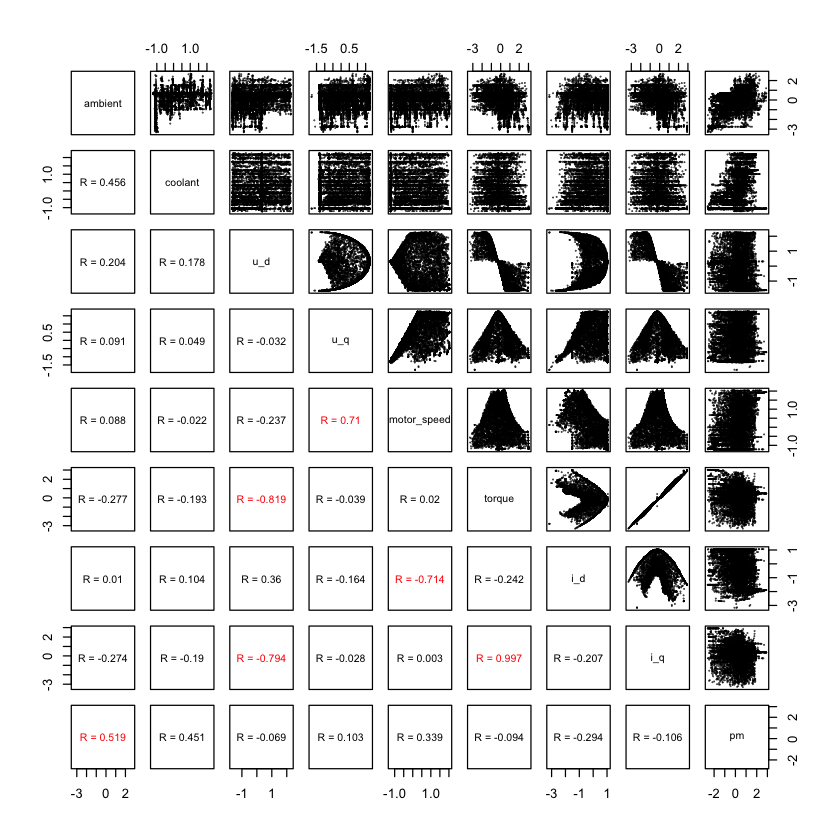

In [10]:
panel.cor <- function(x, y){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- round(cor(x, y), digits=3)
    txt <- paste0('R = ',r)
    text(0.5,0.5, txt, cex = 0.8, 
         col = ifelse(r>0.5 | r< -0.5, 'red','black'))
}
# Customize upper panel
upper.panel<-function(x, y){
  points(x,y, cex =0.1)
}
# Create the plots
pairs(train, 
      lower.panel = panel.cor,
      upper.panel = upper.panel)

# This chunk of code is adapted from Scatter Plot Matrices - R Base Graphs - Easy Guides - Wiki - STHDA, n.d.
# http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs

The scatter plot matrix above is accompanied by a correlation matrix on the lower-half panel. The correlation lower than $-0.5$ and higher than $0.5$ are highlighted with red colour. As we expected, ``torque`` and ``i_q`` forms almost a perfectly straight line with a positive slope. A a result, the distribution of ``torque`` and ``i_q`` look almost identical when plotted with other attributes. 

Some insights from the relationships between each variable are listed below: 

* **``ambient``**  
  
    For ``ambient``, it shows almost no linear relationship with other features. We can see a moderate positive correlation between ``ambient`` and ``pm``, as well as ``coolant``, and such linear relationship is captured by the correlation calculated before. For linear model, therefore, we can assume that ``ambient`` could be a relevant feature when predicting ``pm`` using a linear regression model.
    
    
* **``coolant``**  
  
    Similar to ``ambient``, `coolant` also does not show any linear relationship with any attributes other than ``pm``. There is a weak correlation between `coolant` and `ambient` as we saw above. Similarly we can also see that ``coolant`` also has a moderate positive correlated to ``pm``. As such, as could also assume that ``coolant`` could be a relevant feature for predicting ``pm`` using a linear model.

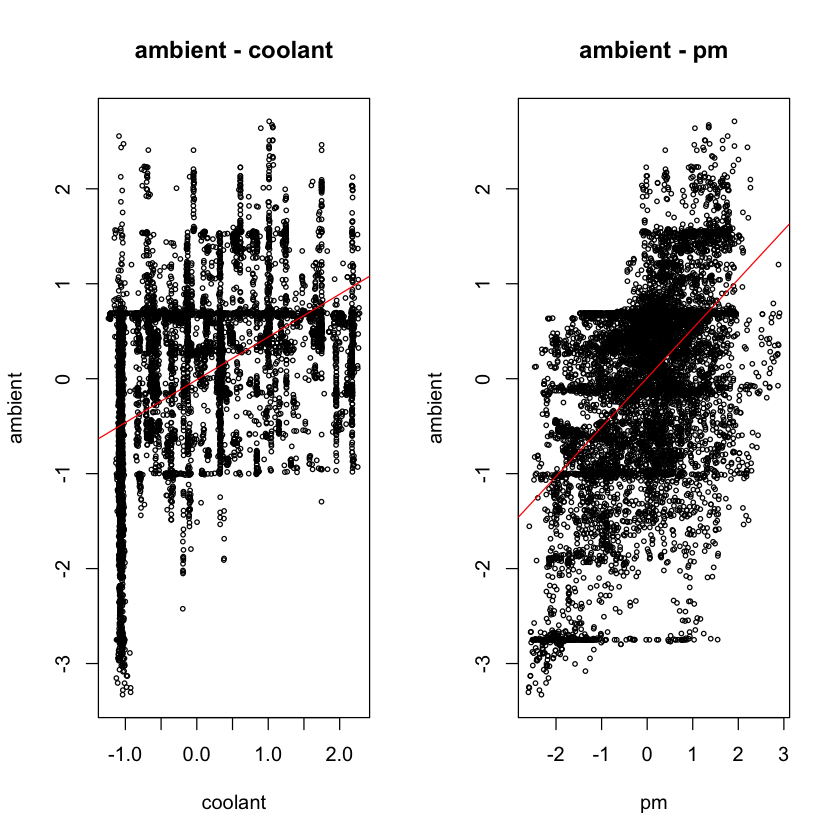

In [11]:
par(mfrow = c(1,2))
plot(train$coolant, train$ambient, main = 'ambient - coolant', cex = 0.5, ylab = 'ambient', xlab = 'coolant')
abline(lm(train$coolant~train$ambient), col = 'red')
plot(train$pm, train$ambient, main = 'ambient - pm',cex = 0.5, ylab = 'ambient', xlab = 'pm')
abline(lm(train$pm~train$ambient), col = 'red')

* **``u_d``**  
  
  ``u_d``, on the other hand, does not seem to have any linear relationship with the target variable ``pm``. However, through the scatter plots, we can observe some non-linear relationship between ``u_d`` and other predictor variables. As an instance, ``torque`` and ``u_d`` have a high negative correlation of $-0.819$. However, the scatter plot of two variables is displaying inconsistant residuals along the regression line. This could be explained by the distribution of both variables that we saw in section 2.1, where both variables have very fat tails at both sides of the curve. The outliers of both features were influential enough to leverage the linear relationship between two variables. If we remove the outliers of residuals from `u_d` - `torque` linear regression model, two features might be able to obtain even stronger correlation with another. 

    Additionally, ``u_d`` and ``u_q``, as well as ``i_d`` and ``u_d`` seem to have a non-linear relationship between another, which was not able be captured by the correlation matrix. Both scatter plots are portraying a rotated parabolic shape, symmetrical at the centre of `u_d`. 
    
    Finally, according to the scatter plot of `u_d`~`pm`, there seem to be no linear relationship between the two variables. The distribution of `u_d` seems very random based on the change in `pm`. This aligns with the 0 correlation of both variables, and we can deduce that `u_d` might not be a relevant predictor when predicting `pm` using simple linear regression.

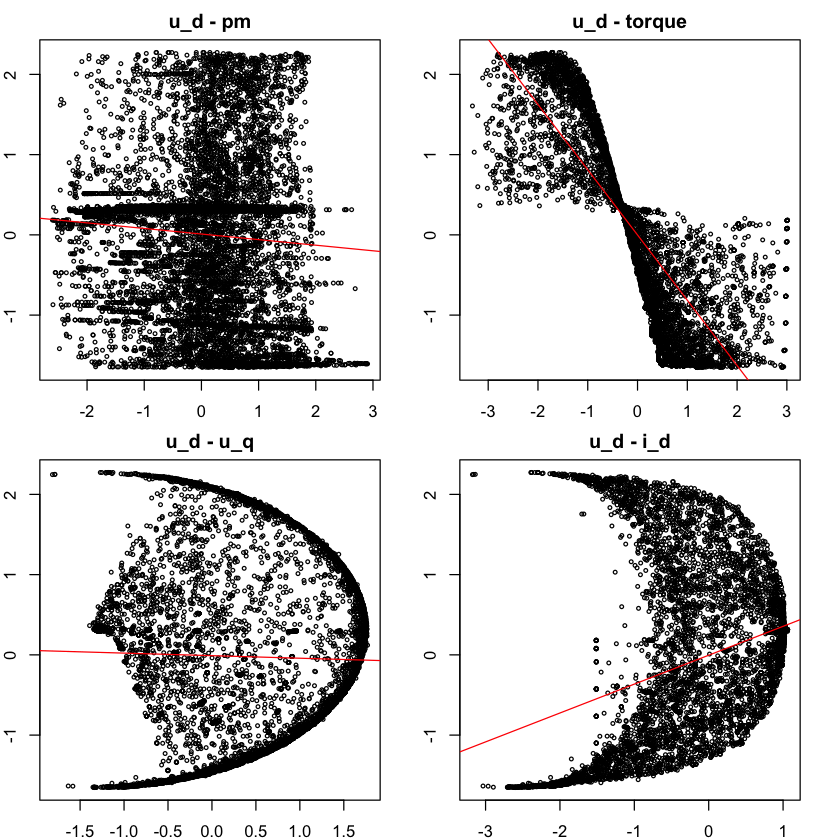

In [12]:
par(mfrow = c(2,2), mar = rep(2,4))
plot(train$pm, train$u_d, main = 'u_d - pm', cex = 0.5)
abline(lm(train$pm~train$u_d), col = 'red')
plot(train$torque, train$u_d, main = 'u_d - torque', cex = 0.5)
abline(lm(train$u_d~train$torque), col = 'red')
plot(train$u_q, train$u_d, main = 'u_d - u_q', cex = 0.5)
abline(lm(train$u_d~train$u_q), col = 'red')
plot(train$i_d, train$u_d, main = 'u_d - i_d', cex = 0.5)
abline(lm(train$u_d~train$i_d), col = 'red')

* **``u_q``**

    Similar to ``u_q`` and ``u_d``, ``torque`` and ``u_q`` also have a correlation close to $0$, and yet two variables portray a non-linear relationship with each other. The scatterplot is showing a symmetrical triangular shape along the red regression line. 
    
    The scatterplot of `u_q~pm` also shows neither a linear nor a non-linear relationship with another. As a result, `u_q` also might not be a relevant predictor in a linear model predicting `pm`. 

    `u_q` and `motor_speed` had a very strong positive correlation of 0.7105. While a lot of data points on the scatter plot are concentrated along the regression line in red, some influential points are pulling the regression line upwards. This might be also the result of right-skewed distribution of `motor_speed` and `u_q`. 
    The scatter plot of `u_q - motor_speed` and `u_q - i_d` look almost similar, but the regression line in the latter shows a negative slope. 

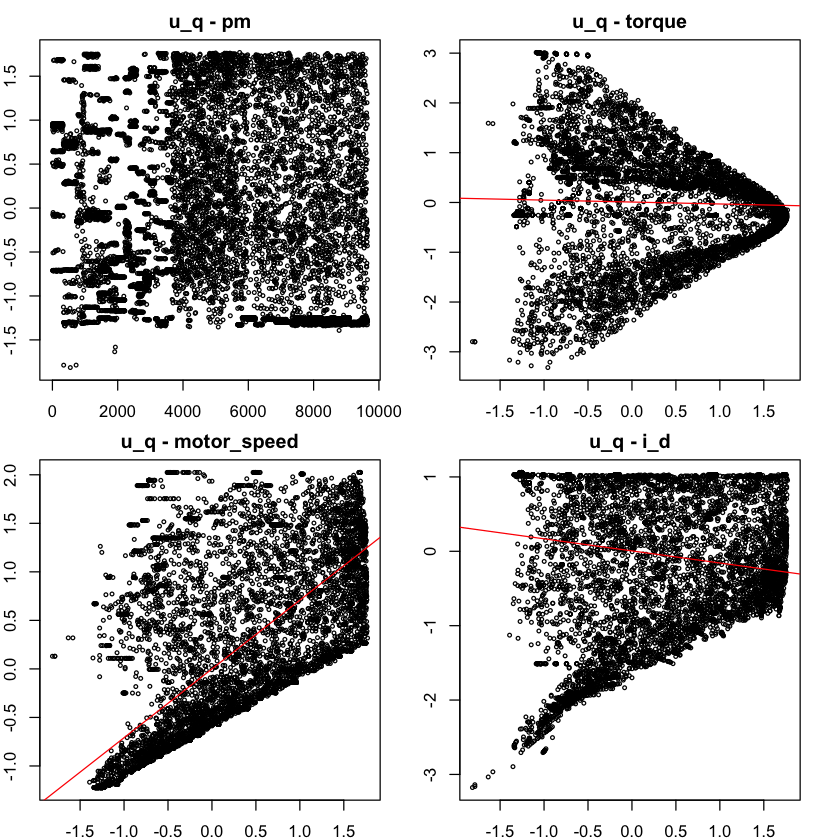

In [13]:
par(mfrow = c(2,2), mar = rep(2,4))
plot(train$u_q, train$om, main = 'u_q - pm', cex = 0.5)
plot(train$u_q, train$torque, main = 'u_q - torque', cex = 0.5)
abline(lm(train$u_q~train$torque), col = 'red')
plot(train$u_q, train$motor_speed, main = 'u_q - motor_speed', cex = 0.5)
abline(lm(train$u_q~train$motor_speed), col = 'red')
plot(train$u_q, train$i_d, main = 'u_q - i_d', cex = 0.5)
abline(lm(train$u_q~train$i_d), col = 'red')

* **``motor_speed``**

    Similar to the scatterplot of ``torque`` and ``u_q``, the scatter plot of ``torque`` and ``motor_speed`` also shows a symmetrical and triangular shape. Such linear relationship was also not caught by the correlation between the variables. 
    
    `motor_speed` showed a very weak positive correlation of 0.3389 with the target variable `pm`. However, it is very hard to see such linear relationship visually through the scatter plot. 
    
    `motor_speed` and `i_d` had a strong negative correlation of -0.7 - the increase in `i_d` is related to the decrease in `motor_speed`. Due to the highly left-skewed distribution of `i_d`, the linear regression line of `pm~i_d` is also pulled to the left with the influential outliers. If we remove these outliers from `i_d`, the correlation of two variables might become stronger. 

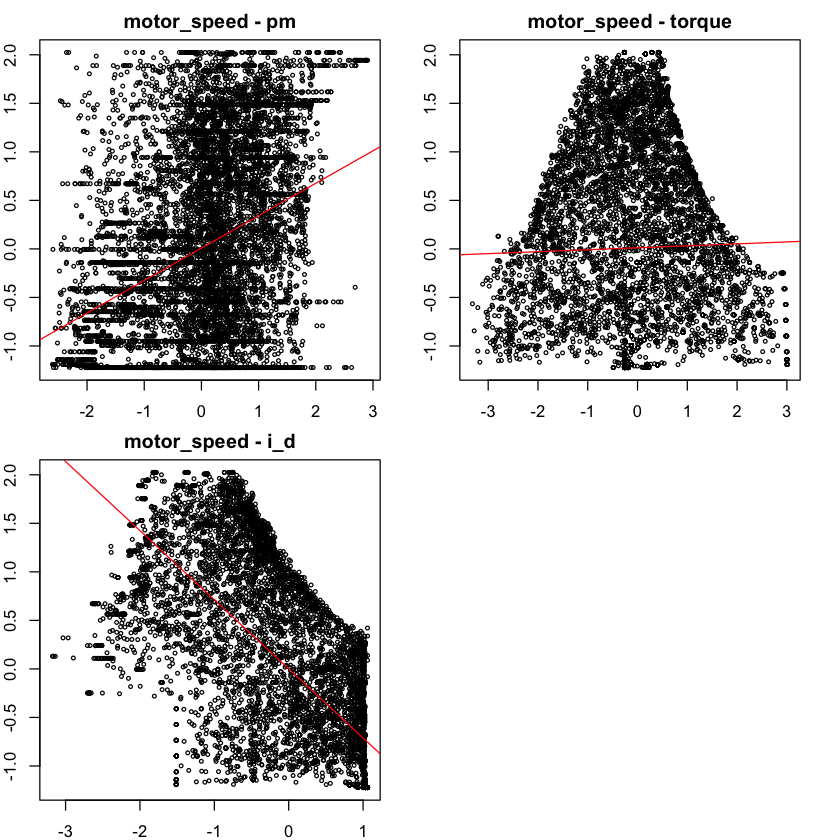

In [14]:
par(mfrow = c(2,2), mar = rep(2,4))
plot(train$pm, train$motor_speed, main = 'motor_speed - pm', cex = 0.5)
abline(lm(train$motor_speed~train$pm), col = 'red')
plot(train$torque, train$motor_speed, main = 'motor_speed - torque', cex = 0.5)
abline(lm(train$motor_speed~train$torque), col = 'red')
plot(train$i_d, train$motor_speed, main = 'motor_speed - i_d', cex = 0.5)
abline(lm(train$motor_speed~train$i_d), col = 'red')

**Conclusion**: 

Through the exploration of linear relationship amongst the features, we can conclude the follow: 

* ``i_q`` and ``torque`` are close to perfectly linearly related. When fitting a linear model to predict ``pm``, we should exclude one of them due to colinearity.  
  
  
* ``u_d`` and ``torque``(``i_q``) are very strongly correlated to another. When using a linear model. Similarly, ``i_d`` and ``motor_speed`` are also strongly correlated to another, which could indicate that these two variables are not independent from another. 
  
  
* ``ambient`` and ``coolant`` have positive correlation with the target variable ``pm``. ``motor_speed`` have a weak positive correlation with ``pm``.
  
  
* Despite a 0 correlation between another, ``torque``(``i_q``) - ``i_d``, ``u_d`` - ``i_d``, and ``u_q``-``u_d`` seem to have non-linear relationships according to the scatter plots. 

# 3. Methodology & Model Development<a class="anchor" id="sec_3"></a>

To predict the target variable ``pm``, we can either utilise non-parametric or parametric models. Since ``pm`` is a continuous numerical variable, we should use regression models as our predictive model. To evaluate the regression model, we can use various metrics such as RMSE (the errors), $R^2$ (the fit), information criterions (errors with penalties n model complexity), or adjusted $R^2$ (the fit with penalties on model complexity). For all the models, I will primarily use **RMSE** and **$R^2$** to evaluate the model. 

Following are the models I will built to predict `pm`: 

* [Non-Parametric](#sec_3.1)
    * [KNN Regression](#sec_3.1.1)
    * [Random Forest Regression](#sec_3.1.2)
    
* [Parametric](#sec_3.2)
    * [Multiple Regression](#sec_3.2.1)
    * [Polynomial Regression](#sec_3.2.2)
    * [Stepwise Regression](#sec_3.2.3)
    * [Shrinkage Methods](#sec_3.2.5)
        * Ridge Regression 
        * Lasso Regression 
        * Elastic Net Regression

## 3.1 Non-Parametric Model<a class="anchor" id="sec_3.1"></a>

Unlike parametric models, where we must look for the most optimal parameters with various assumptions, non-parametric models do not need explicit assumptions on parameter estimation. However, the non-parametric models have tendency to overfitting especially when we do not have enough sample data at hand. 

According to the results from the EDA above, we have some predictors that are very strongly correlated to another. The training data set also have sufficiently large number of observations. Due to its lack of assumptions for parameter estimation, a non-parametric model could be an optimal choice for electric motor temperature prediction. The large sample size of the training data set could also overcome the tendency of overfitting.

For a non-parametric approach, I am using KNN regression and random forest regression for predicting the target. 

### 3.1.1 KNN Regression<a class="anchor" id="sec_3.1.1"></a>

To build the KNN regression, no assumptions are necessary for parameter estimation. The only hyperparameter needed for adjustment is **k** for the model. The model is created by calculating the average of each target observation and its k-nearest neighbours. The lower the **k**, the more overfitting the model becomes. To look for the most optimised **k**, I am using a 10-folds cross validation from ``caret`` package by utilising different **k**s - every 4th integer ranging from 1 to 100. As such, I'll have 25 **k**s in total for testing. 

At each validation from each fold, I will store the *rmse* and *r-squared* as the evaluation metrics for KNN regression model. These metrics are the validation error metrics for models with each k. Additionally, I will also fit in each **k** to the training data as a whole and store the training RMSE and $R^2$. Then, I will plot out the validation and training metrics of each **k** using a line graph. The **k** that returns the highest the $R^2$ and the lowest the rmse for from the validation process will be the optimal **k**. 

In [15]:
features <- names(train)[-length(train)]
# extracting feature names from the train data set

In [16]:
rmse <- function(model, dataset){
    pred <- predict(model, dataset[,features])
    return (sum((pred-dataset['pm'])^2)/nrow(dataset))
}
# a function that calculates RMSE after inputting the fitted model and the dataset 

In [17]:
library(caret)

Loading required package: lattice


In [18]:
library(caret)

training.error <- c()
k.range <- seq(1,100,4)
# range of K for validation and training 

for (k in k.range){
    fit <- knnreg(train[,features],train$pm, k = k)
    training.error <- c(training.error, rmse(fit, train))
    # loop through each k and store the RMSE of each model 
}

trControl <- trainControl(method  = "cv", number  = 10)
# cross validation configuration, 10-folds 
fit <- train(pm ~ .,
             method     = "knn",
             tuneGrid   = expand.grid(k = k.range),
             trControl  = trControl,
             metric     = "RMSE",
             data       = train)
# cross validaiton using procedure using each k 

In [19]:
rmses <- data.frame(training.error, fit$results$RMSE, k.range, fit$results$Rsquared)
# store all the training and validation metrics of each k into a data frame 
names(rmses) <- c('train.rmse', 'k.folds.rmse', 'k', 'k.folds.rsquared')

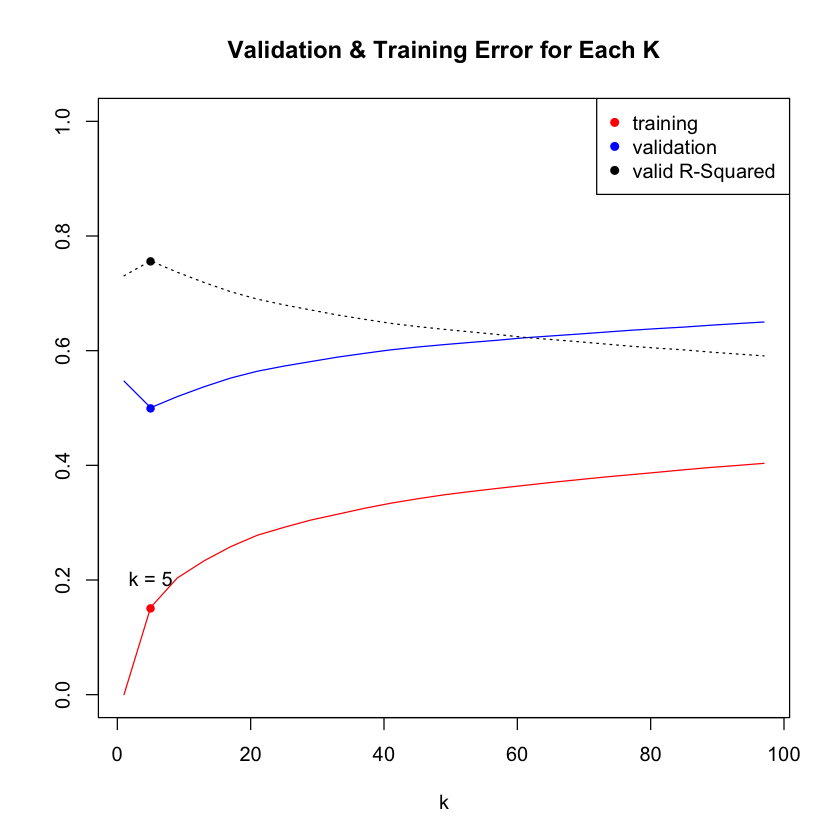

In [20]:
plot(rmses$train.rmse~rmses$k, 
     type = 'l', 
     ylim = c(0,1), 
col = 'red', 
     xlab = 'k', ylab = '', main = 'Validation & Training Error for Each K')
lines(rmses$k.folds.rmse~rmses$k, col = 'blue')
lines(rmses$k.folds.rsquared~rmses$k, lty = 'dotted', col = 'black')
legend('topright', 
       legend = c('training', 'validation', 'valid R-Squared'),
       col = c('red', 'blue', 'black'), 
       pch = 16,
       cex = 1)
text(x = 5, y = rmses$train.rmse[2]+0.05, label = 'k = 5')
suppressWarnings(text(x = 5, y = rmses$train.rmse[2], label = '●', col = 'red'))
suppressWarnings(text(x = 5, y = rmses$k.folds.rmse[2], label = '●', col = 'blue'))
suppressWarnings(text(x = 5, y = rmses$k.folds.rsquared[2], label = '●', col = 'black'))

The plot above shows the changes of training RMSE, validation RMSE, and validation $R^2$ along with the change of `k`. 
We can see that the validation error is the lowest at ``k = 5``. The $R^2$, which is another metrics for evaluating the performance of he regression model to a null model, is also the highest when ``k = 5``. Both metrics suggest that the KNN regression performs the best when `k = 5`.  The training error, on the other hand, is the lowest at ``k = 1``, and it increases as ``k`` increases. This is due to the fact that lower ``k`` has tendency to overfit to the training data, and the higher the ``k``, the more generalised the model becomes. The training error increases very quickly at `k = 5`, and shows a steady and increase after it. 

Through the result displayed from this plot, I decided that the final `k` for the KNN regression model is `k = 5`. 

In [21]:
rsq <- function(rmse, trainset = train){
    1-(rmse/(mean((mean(trainset$pm)-trainset$pm)^2)))
}

In [22]:
knn.cv.result <- rmses[rmses$k == 5,]
knn.cv.result['train.rsquared'] <- rsq(knn.cv.result$train.rmse)
knn.cv.result <- knn.cv.result[,-3]
knn.cv.result['model'] <- 'knn'

In [23]:
knn.cv.result

train.rmse k.folds.rmse k.folds.rsquared train.rsquared model
2 0.1522295  0.5005478    0.756642         0.8515766      knn

In [24]:
knn <- knnreg(x = train[,features], y = train$pm, k = 5)

The KNN model, after setting `k = 5`, yield a validation error of 0.5005 and $R^2$ of 0.7566. The training RMSE is far smaller than that of validation. This shows that the KNN model has a tendency to be overfitted to the training data. The validation $R^2$ of 0.7566 is relatively high and it implies that our model is performing signifcantly better than a null model. 

The major shortcoming of KNN model, outside of its tendency to **overfitting**, is the **inability for interpretation** due to lack of parameters. The model cannot demonstrate the possible relationship between the features and the target. 

### 3.1.2. Random Forest Regression<a class="anchor" id="sec_3.1.2"></a>

Random forest regression, similar to KNN regression, is a non-parametric model which requires no assumptions on the parameter esimations. The model generates pre-defined number of decision tree regression models with randomly bootstrapped samples and randomly selected features. The test error of the random forest model is evaluted using out-of-bag (OOB) samples, which works at a built-in validation set. Therefore, the OOB are great indicator of the hyperparamters of random forest model. `randomForest` package offers a random forest training function as well as hyperparameter tuning function. These two functions generates a visual plot of OOB plot to range of each hyperparameter. 

This model requires two hyperparameters: 

* `mtry`: referring to the number of variable candidates to consider at each split
* `ntree`: referring to the number of trees to generate 

First, I defined the `ntree` parameter using built-in function from `randomForest()`. This function generates the OOB error of up to `ntree = 500` and is able to generate a OOB-ntree line graph. With the returned line graph and OOBs, I will define the most optimal `ntree` first. 

With the optimal `ntree` parameter, I will use `tuneRF` function to optimse the `mtry` paramter. Similar to `randomForest` function, the `tuneRF` function also returns a list of OOB and respective `mtry` value. The most optimal `mtry` will be decided with elbow method on the OOB Error to mtry line graph.



In [25]:
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



0.09396196 0.01 
0.04929411 0.01 
0.04728374 0.01 
0.005826225 0.01 


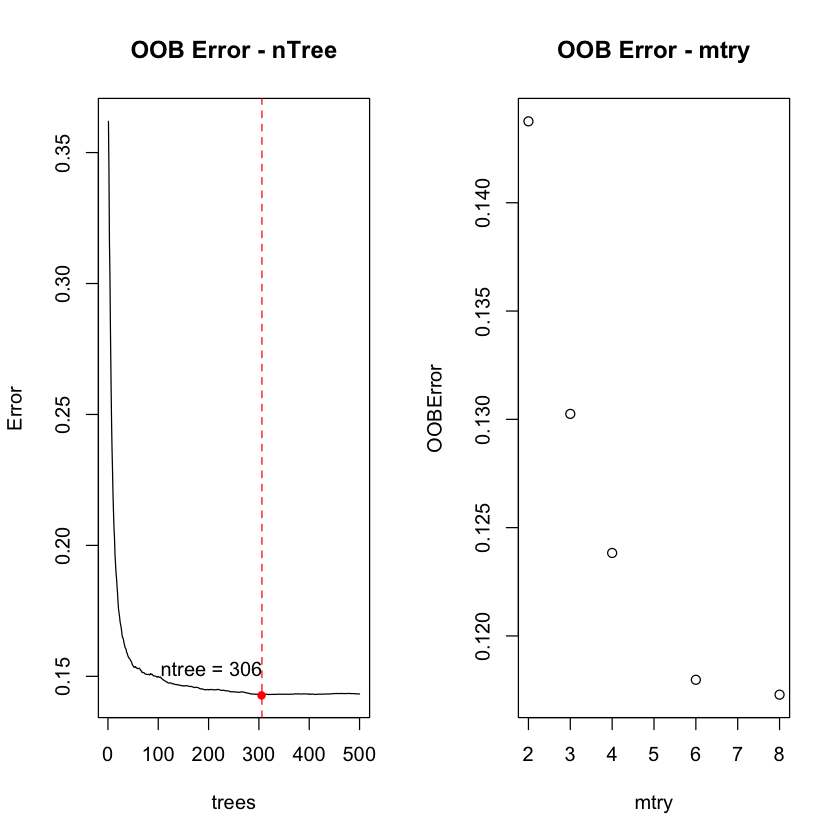

In [26]:
fit <- randomForest(pm~., data = train)
# fit the training data to all the features to randomForest function 
# fit stores the OOB error of each and every nTree ranging from 1 to 500. 
tune.fit <- tuneRF(x = train[features], y = train$pm,
                  ntreeTry = which.min(fit$mse), 
                   # ntree with the least OOB error from fit 
                   mtryStart = 2,
                   # the minimum value of mtry to start with 
                  stepFactor = 1.5, 
                   # increase mtry by 1.5 factor
                   improve = 0.01, 
                   # OOB error threshold to stop increasing mtry
                   # if the new mtry does not increase mse by 10%, stop 
                   trace = F, plot = F)
par(mfrow = c(1,2))
plot(fit, main = 'OOB Error - nTree')
abline(v = which.min(fit$mse), col = 'red', lty = 2)
text(x = which.min(fit$mse) -100, 
     y = fit$mse[which.min(fit$mse)]+0.01, label = paste('ntree =',which.min(fit$mse)))
suppressWarnings(text(x = which.min(fit$mse), 
                      y = fit$mse[which.min(fit$mse)], label = '●', col = 'red'))
plot(tune.fit, main = 'OOB Error - mtry')

The `OOB Error - ntree` shows that the OOB error stop decreasing further after `ntree = 100`. The `randomForest` function suggest that the least OOB error occurs when `ntree = 306`. This is the ntree parameter that I used to tune `mtry`. 

For `mtry` parameter, the OOB is steadily decreasing until `mtry = 8`. This means that all features are to be considered at each split of a decision tree regression model. 

Through the visualisation and tuning process, the the most optimal random forest model hyperparametres are set at `ntree = 306` and `mtry = 8`. 

In [27]:
rf <- randomForest(pm~., ntree = which.min(fit$mse), mtry = 8, data = train)

In [28]:
oob.error <- data.frame(tune.fit)

In [29]:
rf.cv.result <- data.frame(model = 'random forest',
          k.folds.rmse = oob.error[4,2],
          k.folds.rsquared = rsq(oob.error[4,2]),
          train.rsquared = max(rf$rsq),
          train.rmse = min(rf$mse))

In [30]:
rbind(rf.cv.result, knn.cv.result)

model         k.folds.rmse k.folds.rsquared train.rsquared train.rmse
1 random forest 0.1179757    0.884974         0.8862022      0.1167160 
2 knn           0.5005478    0.756642         0.8515766      0.1522295

The training error and the OOB error of the random forest model are almost identical, and this also applies to the $R^2$ metric.  When comparing it to the KNN regression model, the validation error and $R^2$ of random forest model are significantly better. 

However, the random forest model also suffers from a similar shortcoming as the KNN model - low interpretability. The model cannot explain the relationships between each features to the target. Additionally, depending on the hyperparmetres and the sample size, the model can be computationally expensive. 

## 3.2 Parametric Model<a class="anchor" id="sec_3.2"></a>

To utilise parametric regression models, we must make some assumptions for estimating the parameters of our models. For the listed regression models below, we are estimating the parameters of each model using the maximum likelihood estimators, where the independence of each observation should be ensured. Additionally, the residuals of linear models should also satisfy the normality assumption, where the residuals of regression models should be normally distributed. Finally, features with very high correlation should be inspected and removed for simple regression models since it might not improve the predictive performance of the model, but could also add more noises for prediction.

For parametric linear models, I will use the following: 

* [Multiple Regression](#sec_3.2.1) 
* [Polynomial Regression](#sec_3.2.2) 
* [Models with Feature Sub-Selection Methods](#sec_3.2.4)
    * Hybrid Stepwise Regression with BIC
    * Hybrid Stepwise Regression with AIC
* [Models with Shrinkage Methods](#sec_3.2.5)
    * Lasso Regression
    * Elastic Net Regression
    * Ridge Regression 

### 3.2.1. Multiple Regression Model<a class="anchor" id="sec_3.2.1"></a>

To fit the features into a multiple regression model, I manually removed features with high correlations with others - `i_q` and `u_q`. Then, I created the residual plots and QQplot of the residuals in order to check the normality of residuals from multiple regression model, as well as to check the possible outliers. 

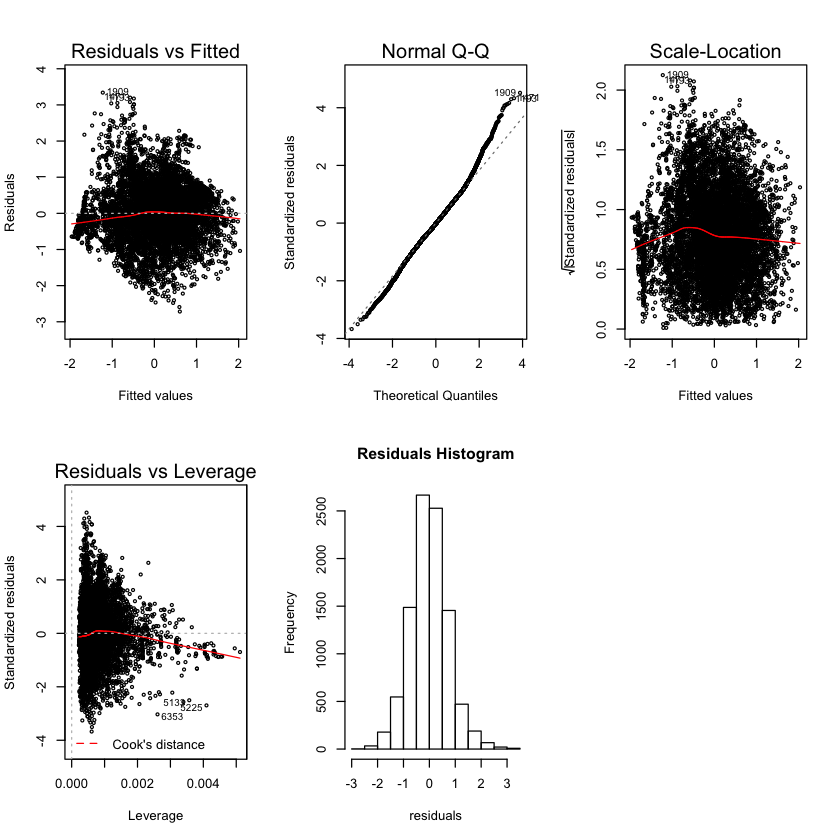

In [31]:
multiple.regression <- lm(pm~.-i_q-u_q, train)
par(mfrow = c(2,3))
plot(multiple.regression, cex = 0.5)
hist(multiple.regression$residuals, main = 'Residuals Histogram', xlab = 'residuals')

Above are different plots of residuals from the multiple regression model. Through the first and the lower-left plot, we can observe that the residuals are randomly distributed without signs of heteroscedasticity or non-linear patterns. The QQplot suggests that the shape of the distribution is close to normal with some possible outliers skew to the right side of the plot. The histogram, on the other hand, displays a normally distributed residuals with a bell curve shape. Multiple regression, unlike non-parametric models, is very sensitive to influential outliers. Therfore, removing influential points with high leverage of the model is critical. Visually, no influential outliers are detected from residual plots or cook's distant plot. 

In [32]:
summary(multiple.regression)


Call:
lm(formula = pm ~ . - i_q - u_q, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7167 -0.4593 -0.0191  0.4539  3.3401 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.007070   0.007531   0.939    0.348    
ambient      0.366609   0.008612  42.568   <2e-16 ***
coolant      0.319443   0.008511  37.533   <2e-16 ***
u_d         -0.265252   0.014168 -18.721   <2e-16 ***
motor_speed  0.109203   0.011483   9.510   <2e-16 ***
torque      -0.199003   0.014038 -14.176   <2e-16 ***
i_d         -0.209271   0.011382 -18.386   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7397 on 9645 degrees of freedom
Multiple R-squared:  0.467,	Adjusted R-squared:  0.4666 
F-statistic:  1408 on 6 and 9645 DF,  p-value: < 2.2e-16


Above is the summary of the multiple regression model. All 6 features in the model have non-zero coefficients, and $H_0: \beta_j = 0$ are all rejected with very low `Pr(>|t|)`. This means that all features are linearly related to the target and are significant in predicting `pm` in this linear model. The coeffcient estimate is the amount change of `pm` along with 1 unit increase of the relevant feature. As an instance, this multiple regression model suggests that 1 unit of increase in `u_d` decreases `pm` by 0.2653, while 1 unit increasse of `ambient` increases `pm` by 0.3667. 

The residual standard error of 0.7397, however, is clearly much higher than that of KNN regression model and random forest model. Similarly, $R^2$ is also much lower than those of aforementioned non-parametric regression models. To further predict the performance of this model in with unseen data set, I used 10-fold cross validation with`train` function from `caret` package.

In [33]:
control <- trainControl(method='cv', number=10)
# configure 10-fold cross validation 
mr.cv <- train(pm ~ .-i_q-u_q,method='lm', data = train, metric='RMSE', trControl=control)
mr.original.cv <- train(pm~., method = 'lm', data = train, metric = 'RMSE', trControl = control)
mr.iq.cv <- train(pm ~ .-i_q,method='lm', data = train, metric='RMSE', trControl=control)
# 10-fold cross validation to multiple regression without removing any features

results <- rbind(rbind(mr.cv$results, mr.original.cv$results), mr.iq.cv$results)
results['model'] <- c('i_q, u_q removed', 'none removed', 'i_q removed')
results

To further compare the validation metrics of the multiple regression above, I also cross validated the multiple regression with all the features, and the one with only `i_q` removed. The results from k-fold cross validation suggests that the multiple regression model removing both `i_q` and `u_q` are, in fact, the worst model out of the three. Removing `i_q` does not seem to impact the performance of the multiple regression model, but removing both features significantly worsened the valid RMSE and valid $R^2$.

In [35]:
summary(mr.iq.cv)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8499 -0.4584 -0.0045  0.4584  3.2965 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.008492   0.007355   1.155  0.24829    
ambient      0.367272   0.008411  43.665  < 2e-16 ***
coolant      0.324599   0.008316  39.035  < 2e-16 ***
u_d         -0.158460   0.014692 -10.785  < 2e-16 ***
u_q         -0.345486   0.015976 -21.625  < 2e-16 ***
motor_speed  0.561839   0.023746  23.660  < 2e-16 ***
torque      -0.071670   0.014921  -4.803 1.58e-06 ***
i_d          0.048829   0.016310   2.994  0.00276 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7224 on 9644 degrees of freedom
Multiple R-squared:  0.4916,	Adjusted R-squared:  0.4912 
F-statistic:  1332 on 7 and 9644 DF,  p-value: < 2.2e-16


The training performance of the multiple regression after adding `u_q` back in is actually better than removing it. The lowered RMSE and higher $R^2$ than `multiple.regression` models suggests that the multiple regression model with `u_q` is better at predicting `pm`. All features in this model are all linearly related to `pm`. Therefore, for the multiple regression model, all features without `i_q` is a better model at predicting the target. 

In [36]:
multiple.regression <- lm(pm~.-i_q, train)
mr.train.rmse <- mean((multiple.regression$residuals)^2)
mr.train.rsquared <- rsq(mr.train.rmse)
mr.cv.rmse <- mr.iq.cv$results$RMSE
mr.cv.rsquared <- mr.iq.cv$results$Rsquared

mr.cv.result <- data.frame(model = 'multiple regression',
                          k.folds.rmse = mr.cv.rmse,
                          k.folds.rsquared = mr.cv.rsquared,
                          train.rsquared = mr.train.rsquared,
                          train.rmse = mr.train.rmse)

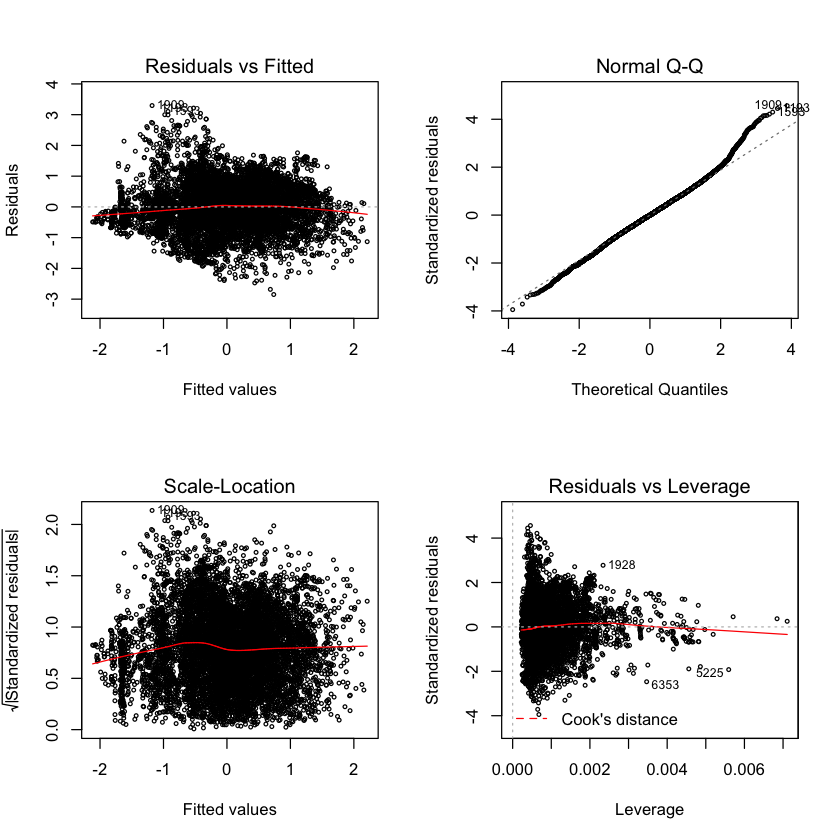

In [37]:
par(mfrow = c(2,2))
plot(multiple.regression, cex = 0.5)

The improved multiple regression function does not have any outstanding influential points observed. The distribution of the residuals from the model also seem roughly normally distributed with some outliers on the right side of the curve. 

In [38]:
mr.cv.result

model               k.folds.rmse k.folds.rsquared train.rsquared train.rmse
1 multiple regression 0.7224551    0.4914876        0.4916132      0.5214238

Despite of its poor performance in comparison to KNN and random forest, one major advantage of the multiple regression model is the interpretability. If all the features had stronger linear relationships, the performance of the multiple regression model could have been enhanced. Through this model, we are able to understand the relationship between each feature and the target - not only the linearity of the relationship, but also the changes of target based on changes of each feature. 

### 3.2.2 Polynomial Regression with Interaction Variables<a class="anchor" id="sec_3.2.2"></a>

Stepwise regression is a regression model with feature selection method. To test out different features and various combinations, I included interactive terms (the product of every two features) and polynomial degree of 3 to all variables. I also removed `i_q` from the features due to its perfect correlation with `torque`. With features sub-selection method models, I will use hybrid stepwise regression with BIC and AIC for feature selection criterion and evaluate each of them with cross validation. 

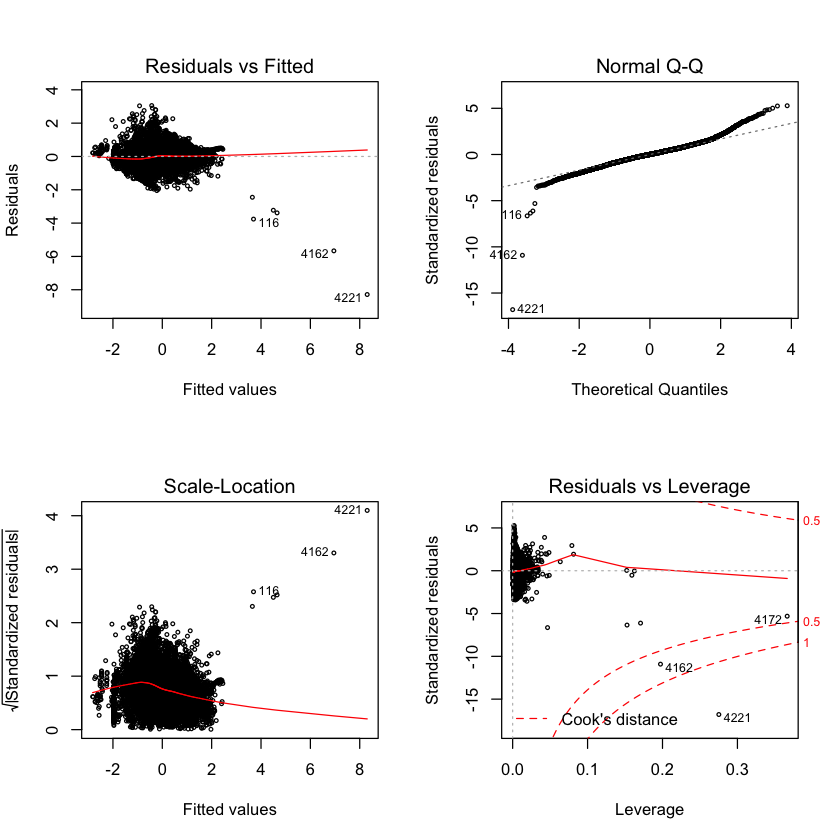

In [39]:
temp <- train[,-8]
# remove i_q from the training data set 
poly.regression <- lm(formula = pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp)
# polynomial regression with the power of 3, as well as interaction variables to the data set excluding i_q
par(mfrow = c(2,2))
plot(poly.regression, cex = 0.5)

The residual plots and cook's distance plot suggest that observation 4221 and 4162 are influential leverage points. In fact, the scale-location plot and the residual plot suggest that the points 4172, 4162, and 116 are not only deviated from the rest of the residuals, but also affecting the slope of the polynomial regression model. The observation 4221 and 4162 are also caught outside of the cook's distance. Cook's distance, which is a method of detecting outliers in regression models, projects the extent of changes in performance of a model after removing each data point. 

Through these four plots, we can conclude that observation 116, 4172 and 4162 are most likely to be the outliers influencing the model. Despite that polynomial regression model is more robust to outliers than simple linear regression model, removing the influential points with high leverage is still critical to the model performance. Therefore, to obtain the better result of fitting, I am removing these observations and fitting the multiple regression model again. 

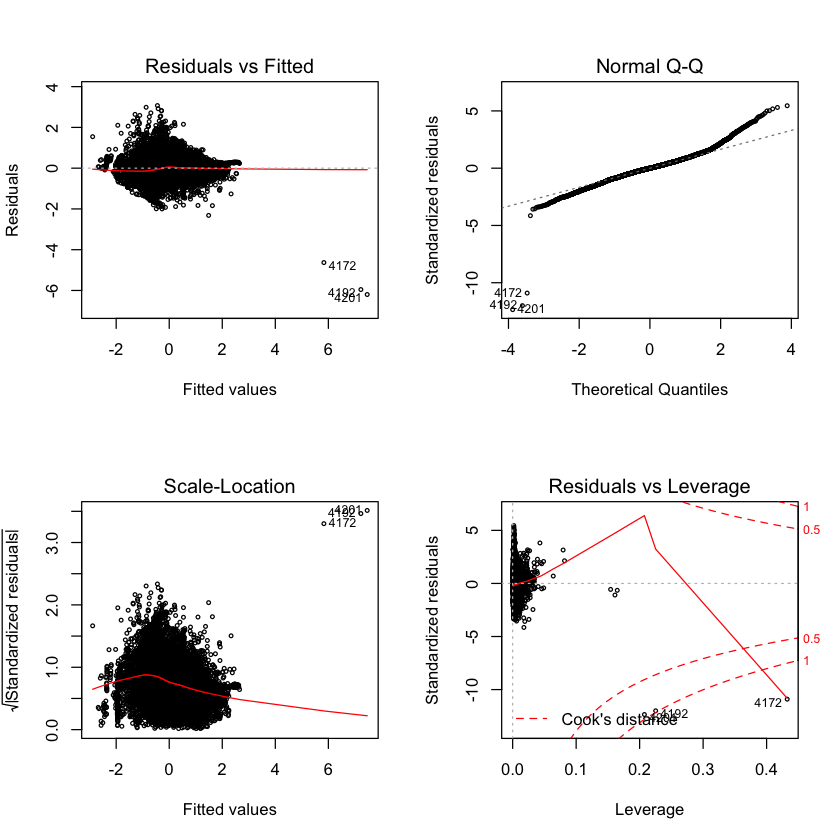

In [40]:
temp <- train[-c(4162, 4221, 116),-8]

poly.regression <- lm(formula = pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp)
par(mfrow = c(2,2))
plot(poly.regression, cex = 0.5)

After removing two influential outliers detected from the first model, three more data points are observed to be influential - observation 4201, 4192, and 4172. The scale-location plot and residual plots are clearly showing that these three points are influencing the slope of the regression model. These three points are also caught in the cook's distance plot, demonstrating that the performance of the regression model changes drastically when removing them. They are also identified as outliers in the QQplot of the residuals, which could violate the normality assumption of the regression models. Therefore, once agian, I am removing these three points from the data and fitting a new polynomial regression model. 

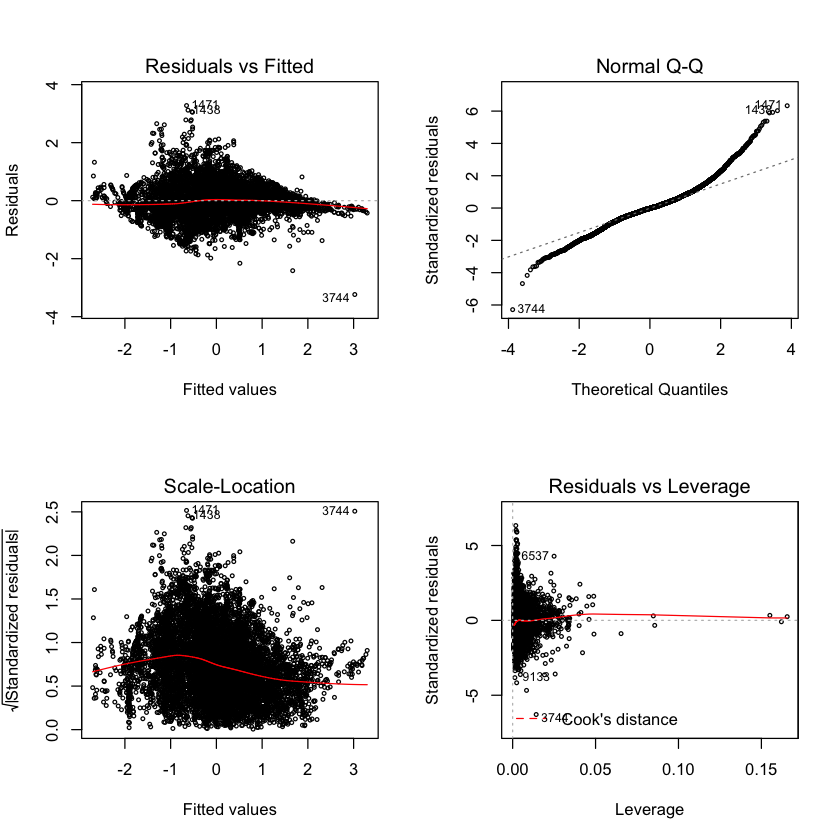

In [41]:
temp <- train[-c(4221, 4172, 4162, 4201, 4192, 116), -8]
poly.regression <- lm(formula = pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp)
par(mfrow = c(2,2))
plot(poly.regression, cex = 0.5)

After removing 6 influential outliers, the residual plots and cook's distance plot looks more stable. The data points 1471, 1438, and 3744 are also identified as outliers based on the QQplot. Especially the observation 3744 seem to have leverage over the performance of the model based on the cook's distance plot. To evaluate how much these points are affecting the result of the models, I am using cross validation to check the performance of the polynomial regression with and without these three data points. 

In [42]:
poly.original.cv <- suppressWarnings(train(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = train, method = 'lm', metric = 'RMSE', trControl = control))
# cross validating the original data set after applying 3rd degree polynomial without removing any outliers 

poly.cv <- suppressWarnings(train(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp, method = 'lm', metric = 'RMSE', trControl = control))
# the 3rd degree polynomial regression after removing influential outliers 

temp.2 <- train[-c(4221, 4172, 4162, 4201, 4192, 116, 1471, 1438, 3744), -8]
# the data set after removing 1471, 1438, 3744
poly.outlier.test <- suppressWarnings(train(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp.2, method = 'lm', metric = 'RMSE', trControl = control))
# the 3rd degree polynomial after removing 1471, 1438, 3744

In [43]:
poly.original <- lm(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = train)
# 3rd degree polynomial without removing any outliers 

poly.regression <- lm(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp)
# the 3rd degree polynomial regression after removing influential outliers 

poly.outlier <- lm(pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 3) + 
               poly(motor_speed, 3) + poly(u_q,3) + poly(u_d, 3) + 
               poly(torque ,3) + .*., data = temp.2)
# the 3rd degree polynomial after removing 1471, 1438, 3744

train.errors <- c(mean(poly.original$residuals^2),
                 mean(poly.regression$residuals^2),
                 mean(poly.outlier$residuals^2))
# obtain the training errors of all three models above 

train.rsq <- mapply(rsq, train.errors)
# calculate the R^2 metrics of all models 

In [44]:
poly.cv.results <- rbind(poly.original.cv$results[,c(2,3,5,6)], 
                     poly.cv$results[,c(2,3,5,6)])
poly.cv.results <- rbind(poly.cv.results, poly.outlier.test$results[,c(2,3,5,6)])
# validation metrics from three models 

poly.cv.results['model'] <- c('Polynomial w/ Outliers', 'Polynomial w/o Outliers', 'Outlier Leverage Test')
poly.cv.results['train RMSE'] <- train.errors 
poly.cv.results['train Rsquared'] <- train.rsq
poly.cv.results[c(5,1,2,6,7,3,4)]

model                   RMSE      Rsquared  train RMSE train Rsquared
1 Polynomial w/ Outliers  0.6043290 0.6506926 0.3269898  0.6811859     
2 Polynomial w/o Outliers 0.5189526 0.7374182 0.2674655  0.7392218     
3 Outlier Leverage Test   0.5158876 0.7403394 0.2643082  0.7423003     
  RMSESD     RsquaredSD
1 0.07204975 0.06536736
2 0.02233290 0.02270479
3 0.01589469 0.01334013

Before removing any of the outliers, the original polynomial regression model had a validation RMSE of 0.5943 and validation $R^2$ of 0.6596. The polynomial regression model after removing the influential outliers performs significantly better than the former one - with an increased $R^2$ of0.7374 and decreased RMSE of 0.5188. This is a very significant improvement from the original model. The model fit to the data after removing 1471, 1438, and 3744 does perform slightly better than the former one, but the improvement is very marginal. Fitting a model after removing these three data points might bring slight improvement in the predictive performance, but we are also losing a lot of information from these data points. Therefore, I will not remove 1471, 1438, and 3744 for the polynomial regression model.

On the other hand, when comparing the training and validation performance of all three models, we can see that the training RMSE and $R^2$ of all models are significantly better than those of validation. This suggests that all three models are are very overfitted to the training data.

In [45]:
summary(poly.regression)


Call:
lm(formula = pm ~ . + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 
    3) + poly(motor_speed, 3) + poly(u_q, 3) + poly(u_d, 3) + 
    poly(torque, 3) + . * ., data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2361 -0.2690 -0.0096  0.2557  3.2790 

Coefficients: (7 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.111833   0.140981  29.166  < 2e-16 ***
ambient                 0.240012   0.008465  28.354  < 2e-16 ***
coolant                 0.074856   0.007806   9.590  < 2e-16 ***
u_d                    -2.168570   0.220089  -9.853  < 2e-16 ***
u_q                   -11.518689   0.165830 -69.461  < 2e-16 ***
motor_speed            14.890922   0.252583  58.955  < 2e-16 ***
torque                 -0.448862   0.248352  -1.807 0.070737 .  
i_d                     8.297799   0.128998  64.325  < 2e-16 ***
poly(i_d, 3)1                 NA         NA      NA       NA    
poly(i_d, 3)2    

The polynomial regression without outliers, ``poly.regression``, has 42 parameters in total with the training error of 0.5183 and training $R^2$ of 0.7392. Numbers of predictors to the power of 2, such as `i_d`^2, `coolant`^2, and `motor_speed`^2 as well as some interaction variables, such as `motor_speed:torque` might not be linearly related to the target. This is demonstrated by the `Pr(>|t|)` higher than 0.05. Overall, the training error and the $R^2$ of the polynomial regression model with interaction variables after removing the outliers perform significantly better than the simple multiple linear regression, which had a RSE close to 0.7 and $R^2$ of 0.45. 

In [46]:
poly.train.rmse <- mean((poly.regression$residuals)^2)
poly.train.rsquared <- rsq(poly.train.rmse)
poly.cv.rmse <- poly.cv$results$RMSE
poly.cv.rsquared <- poly.cv$results$Rsquared

poly.cv.result <- data.frame(model = 'polynomial regression',
                          k.folds.rmse = poly.cv.rmse,
                          k.folds.rsquared = poly.cv.rsquared,
                          train.rsquared = poly.train.rsquared,
                          train.rmse = poly.train.rmse)

### 3.2.3. Hybrid Stepwise Regression with AIC<a class="anchor" id="sec_3.2.3"></a>

The polynomial regression model above was a huge improvement from the simple multiple regression model, but there were some parameters that seem to be not relevant when predicting `pm` using a linear model. To select the relevant features of the model using stepwise regression, I created hybrid stepwise selection method with both AIC and BIC penalties. The AIC, which penalise the model by adding 2* number of parameters to the RSS, is more lineant in selecting parameters in comparison to BIC. BIC's penalises a model by adding log(nrow(dataset)) to the RSS. Based on the number of observations in the data set, the BIC penalty can be either larger than or equal to AIC. For our train data, the number of observation is almost 10,000, which yields BIC penalty close to 9. To evaluate the performance of hybrid stepwise regression models with different information criterions, I utilised 10-fold cross validation and compared their results. 

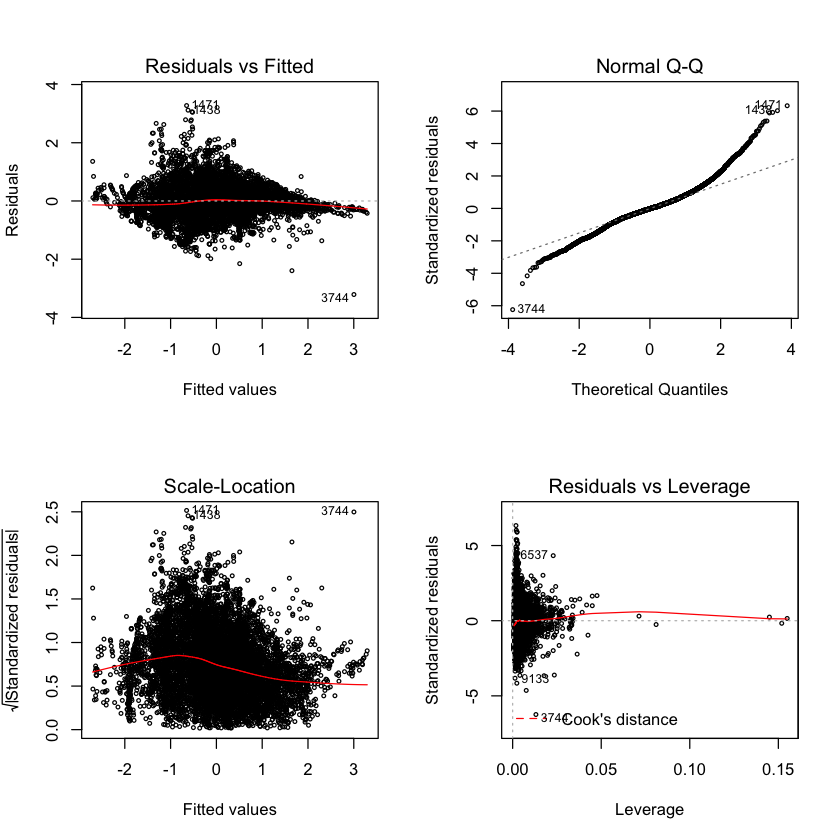

In [47]:
step.aic <- step(poly.regression, direction = 'both', k = 2, trace = F)
par(mfrow = c(2,2))
plot(step.aic, cex = 0.5)

The residual plots of the stepwise regression model with AIC seem almost identical to that of polynomial regression model without influential outliers. The remaining outliers from the ``poly.regression`` model are still observed in the stepwise regression model residual plots. However, overall, the distribution of the residuals in the residual plot seem random, and the QQplot also look close to normal distribution with some fat tails on both side of the curve. 

In [48]:
summary(step.aic)


Call:
lm(formula = pm ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 
    3) + poly(motor_speed, 3) + poly(u_q, 3) + poly(u_d, 3) + 
    poly(torque, 3) + ambient:coolant + ambient:u_d + ambient:u_q + 
    ambient:motor_speed + ambient:i_d + coolant:u_q + coolant:motor_speed + 
    coolant:torque + coolant:i_d + u_d:u_q + u_d:motor_speed + 
    u_d:torque + u_d:i_d + u_q:motor_speed + u_q:torque + u_q:i_d + 
    motor_speed:i_d + torque:i_d, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2137 -0.2682 -0.0077  0.2552  3.2776 

Coefficients: (7 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.049328   0.122225  33.130  < 2e-16 ***
ambient                 0.239546   0.008458  28.323  < 2e-16 ***
coolant                 0.076456   0.007600  10.060  < 2e-16 ***
u_d                    -2.290125   0.132339 -17.305  < 2e-16 

**The metrics from polynomial regression model**

`Residual standard error: 0.5183 on 9603 degrees of freedom
Multiple R-squared:  0.7392,	Adjusted R-squared:  0.7381 `

The hybrid stepwise regression model with AIC successfully reduced 3 features from the polynomial regression model. The interaction variables with high `Pr(>|t|)` of $H_0: \beta_j = 0$ from the polynomial regression model are all removed, but the `motor_speed`, `u_d`, and `i_d` to the power of 2 still remained in the model despite its high `Pr(>|t|)`. This is due to the relevant interactive variables of all three features in the model and their significance in predicting `pm`. `poly(u_q, 3)2` is related to the largest change in pm - one unit increase of `u_q`^2 decreases `pm` by 46.5898. In this model, `motor_speed` by itself is also related to a huge change in `pm` - 1 unit increase of `motor_speed` increases `pm` by 14.788. Through such interpretation, we can also see that the polynomial regression model has some interpretability in comparison to non-parametric models, such as KNN or random forest. 

The performance of the stepwise regression model, however, has not changed at all after removing irrelevant parameters. The RSE remains identical as the polynomial regression model, as well as $R^2$ and the adjusted $R^2$. Nevertheless, this also means that the stepwise regression model is slightly less complex than the original polynomial regression model due to its less number of parameters. 

### 3.2.4. Hybrid Stepwise Regression with BIC<a class="anchor" id="sec_3.2.4"></a>

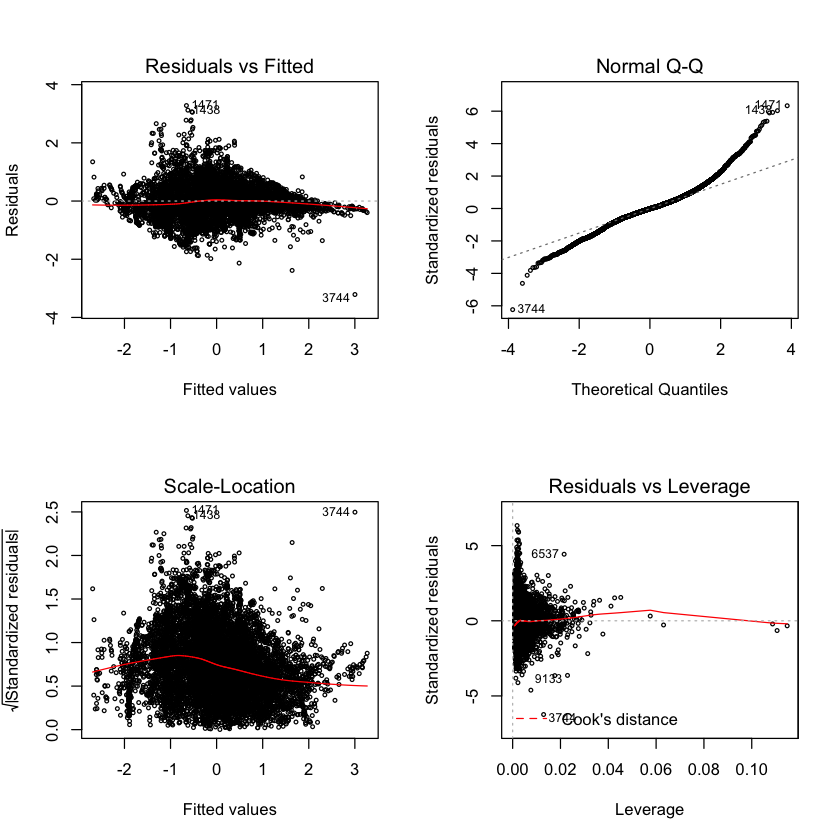

In [49]:
step.bic <- step(poly.regression, direction = 'both', k = log(nrow(train)), trace = F)
par(mfrow = c(2,2))
plot(step.bic, cex = 0.5)

The residual plots and cook's distance plot of stepwise regression model with BIC look exactly the same as that of AIC. 

In [50]:
step.bic <- step(poly.regression, direction = 'both', k = log(nrow(train)), trace = F)
summary(step.bic)


Call:
lm(formula = pm ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + poly(ambient, 3) + poly(coolant, 3) + poly(motor_speed, 
    3) + poly(u_q, 3) + poly(u_d, 3) + poly(torque, 3) + ambient:coolant + 
    ambient:u_d + ambient:u_q + ambient:motor_speed + ambient:i_d + 
    coolant:u_q + coolant:motor_speed + coolant:torque + coolant:i_d + 
    u_d:u_q + u_d:motor_speed + u_d:torque + u_d:i_d + u_q:motor_speed + 
    u_q:torque + u_q:i_d + motor_speed:i_d + torque:i_d, data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2126 -0.2680 -0.0071  0.2563  3.2820 

Coefficients: (6 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.024550   0.074534  53.996  < 2e-16 ***
ambient                 0.240486   0.008452  28.452  < 2e-16 ***
coolant                 0.076602   0.007601  10.078  < 2e-16 ***
u_d                    -2.261351   0.131983 -17.134  < 2e-16 ***
u_q             

**Stepwise Regression Model with AIC**  
`
Residual standard error: 0.5183 on 9606 degrees of freedom
Multiple R-squared:  0.7391,	Adjusted R-squared:  0.7381 
`

Due to large number of observations in the train data set, the BIC penalty was much larger than that of AIC, which resulted in less number of parameters than the former model. After applying BIC, the model deselected 7 features in total, which is 4 more features than the AIC model. The RMSE of BIC model, as well as multiple R^2 of BIC model is slightly worse than the AIC model; however, the adjusted $R^2$ of BIC is slighter better than that of AIC due to less number of parameters involved. 

The summary of the model shows that the  2nd degree and 3rd degree polynomials of `i_d` are all completely removed from the model. This model suggests that the polynomial terms of `i_d` are not linearly related to the prediction of `pm` after applying penalty to the model. Instead, the coefficient estimate of some features, including `poly(u_q, 3)2` and `poly(torque, 3)2` changed significantly in this new model.

To further evalute the performance of these two models, I applied them to 10-fold cross validation and juxtaposed the validation metrics of two models.

In [51]:
bic.cv <- suppressWarnings(
    
    train(pm ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + poly(ambient, 3) + poly(coolant, 3) + poly(motor_speed, 
    3) + poly(u_q, 3) + poly(u_d, 3) + poly(torque, 3) + ambient:coolant + 
    ambient:u_d + ambient:u_q + ambient:motor_speed + ambient:i_d + 
    coolant:u_q + coolant:motor_speed + coolant:torque + coolant:i_d + 
    u_d:u_q + u_d:motor_speed + u_d:torque + u_d:i_d + u_q:motor_speed + 
    u_q:torque + u_q:i_d + motor_speed:i_d + torque:i_d, 
                data = temp, metric='RMSE', trControl=control, method = 'lm')
)

aic.cv <- suppressWarnings(
    
    train(pm ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + poly(i_d, 3) + poly(ambient, 3) + poly(coolant, 
    3) + poly(motor_speed, 3) + poly(u_q, 3) + poly(u_d, 3) + 
    poly(torque, 3) + ambient:coolant + ambient:u_d + ambient:u_q + 
    ambient:motor_speed + ambient:i_d + coolant:u_q + coolant:motor_speed + 
    coolant:torque + coolant:i_d + u_d:u_q + u_d:motor_speed + 
    u_d:torque + u_d:i_d + u_q:motor_speed + u_q:torque + u_q:i_d + 
    motor_speed:i_d + torque:i_d, 
                data = temp, metric='RMSE', trControl=control, method = 'lm')
)

In [52]:
ic.cv.results <- rbind(bic.cv$results, aic.cv$results)
ic.cv.rmse <- ic.cv.results$RMSE
ic.cv.rsquared <- ic.cv.results$Rsquared
ic.train.rmse <- c(mean((step.bic$residuals)^2),
                  mean((step.aic$residuals)^2))
ic.train.rsquared <- c(rsq(mean((step.bic$residuals)^2)),
                      rsq(mean((step.aic$residuals)^2)))
ic.model <- c('BIC', 'AIC')

ic.cv.result <- data.frame(model = ic.model,
                          k.folds.rmse = ic.cv.rmse,
                          k.folds.rsquared = ic.cv.rsquared,
                          train.rsquared = ic.train.rsquared,
                          train.rmse = ic.train.rmse)

In [53]:
t <- rbind(ic.cv.result, poly.cv.result)
rbind(t, mr.cv.result)

model                 k.folds.rmse k.folds.rsquared train.rsquared train.rmse
1 BIC                   0.5193552    0.7368111        0.7388800      0.2678161 
2 AIC                   0.5186478    0.7376638        0.7391396      0.2675498 
3 polynomial regression 0.5189526    0.7374182        0.7392218      0.2674655 
4 multiple regression   0.7224551    0.4914876        0.4916132      0.5214238

The validation error of BIC and AIC models are almost identical, but the AIC one has a slightly higher $R^2$ and lower RMSE. The validation error and $R^2$ metrics of both stepwise regression models are slightly better than the polynomial regression model, and much better than the multiple regression model. When taking number of predictors into account, BIC is so far the model with less complexity but better predictive performance out of the four. Similar to the original polynomial regression model, the BIC and AIC models also have tendency to overfit, observed by the huge difference between training RMSE and validation RMSE. 

### 3.2.5 Shrinkage Methods - Lasso, Ridge, and Elastic Net <a class="anchor" id="sec_3.2.5"></a>

Lasso, ridge, and elastic net methods are model-centre approach of feature selection. These models apply penalties to features by directly changing the coefficient (parameters) of the linear models. A lot of the features of the training data set are highly correlated to another, and yet we also have a huge number of observations available. Elastic Net is, therefore, an optimal choice of model due to its robustness to highly correlated predictors.

Both Lasso and ridge regularisation model requires adjustment of the hyperparameter $\lambda$ to determine the size of parameter shrinkage, while elastic net requires both $\lambda$ and $\alpha$. All models are highly sensitive to the value of $\lambda$ since it determines the extent of penalties applied to each parametre in the model. We can look for an optimised $\lambda$ for all models using in-built cross validation function from glmnet package. For elastic net, the optimal $\alpha$ could be also predicted using cross validation. 

To apply lasso, ridge, and elastic net models, we first need to convert the training data frame into a matrix excluding the features. 

In [54]:
library(glmnet)
feature.matrix <- model.matrix(pm~., data = train)[, -1]

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



#### 3.2.5.1 Lasso, Ridge, and Elastic Net Regression

For Ridge, Lasso, and standard elastic net regresion, I am able to obtain the optmise $\lambda$ using `cv.glmnet` since $\alpha$ is fixed for each model. By specifying `lambda.lse` from the returned value of `cv.glmnet`, the most optimsed $\lambda$ for the specified $\alpha$ is returned. 

In [55]:
lasso.cv <- cv.glmnet(feature.matrix, train$pm, type.measure = 'mse', alpha = 1, family = 'gaussian')
lasso <- glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = 1)
lasso.cv$lambda.1se

[1] 0.02940268

In [56]:
ridge.cv <- cv.glmnet(feature.matrix, train$pm, type.measure = 'mse', alpha = 0, family = 'gaussian')
ridge <- glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = 0)
ridge.cv$lambda.1se

[1] 0.1106992

In [57]:
elastic.net.cv <- cv.glmnet(feature.matrix, train$pm, type.measure = 'mse', alpha = 0.5, family = 'gaussian')
elastic.net <- glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = 0.5)
elastic.net.cv$lambda.1se

[1] 0.03365059

For the optimal $\lambda$ of each shrinkage model, a built-in cross validation function from ``glmnet`` returns it based on the least MSE. These `lambda.min` are the $\lambda$ that we will use after choosing the best model out of the three. 

For elastic net model, we also need to look for the most optimal $\alpha$. This could also be achieved using k-folds cross validation. For ``glmnetUtils`` library, a built-in function called ``cva.glmnet`` performs cross validation at each $\alpha$ with every $\lambda$ possible. With this function, we can obtain the most optimal $\alpha$ and $\lambda$ combination for elastic net model.

In [58]:
library(glmnetUtils)

cva <- cva.glmnet(pm~., data= train)
get_cvm <- function(cva) {
   index <- match(cva$lambda.1se, cva$lambda)
  cva$cvm[index]
}

enet_performance <- data.frame(alpha = cva$alpha)
models <- cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
(best_alpha <- cva$alpha[minix])


Attaching package: ‘glmnetUtils’

The following objects are masked from ‘package:glmnet’:

    cv.glmnet, glmnet



[1] 0.512

In [59]:
elastic.net.alpha.cv <- cv.glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = best_alpha)
elastic.net.alpha <- glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = best_alpha)

The plots on the left hand side below are the changes of each feature coefficients based on $\lambda$ value for each model. The $\lambda$ values on the x-axis are all logged for better interpretation. The most right side of each of these plots with the maximum value of `Log Lambda`, where $\lambda$ is close to 0, is the standard multiple regression model after fitting every single features. The lower the `Log Lambda`, the higher the penalty and thus less significant the coefficients become. The rightest side of each plot are when $\lambda \to \infty$, where all coefficients are shrunk to 0. Each line stands for the coefficient of each feature in the model. 

The plots on the right side are the results of cross validation on each lambda at the specified $\alpha$. The curve is the changes in MSE for each $\lambda$. The two dotted vertical lines in these plots stand for $\lambda$ with the least estimated test error, and $\lambda$ with the least sample error respectively. The integers on top of these plots are the number of features remain in the model at each $\lambda$. 

Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos


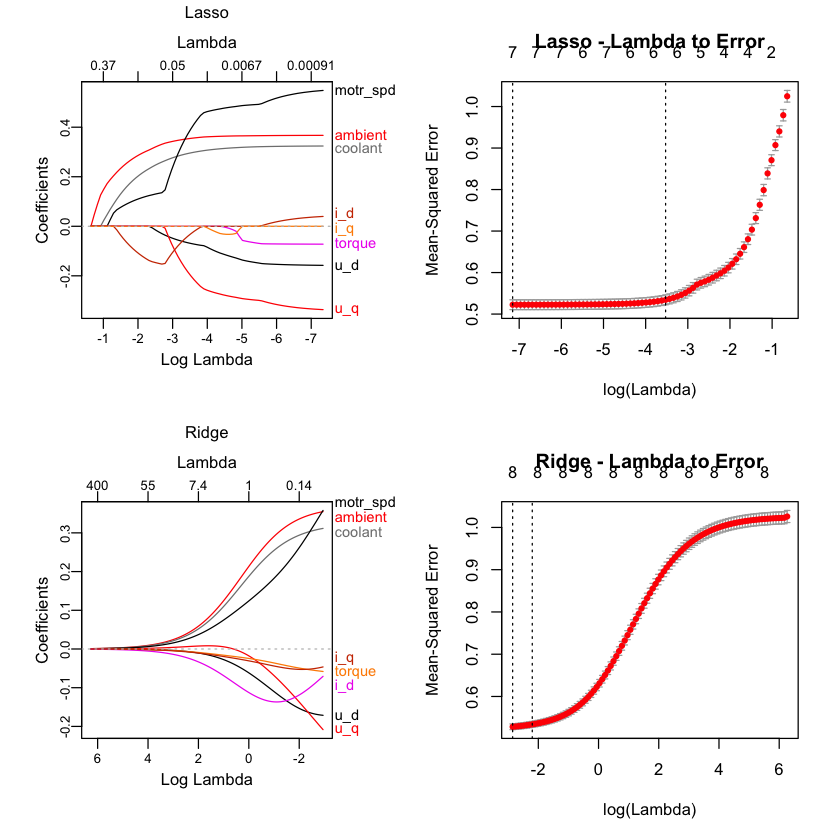

In [60]:
library(plotmo)
par(mfrow = c(2,2))
plot_glmnet(lasso, main = 'Lasso')
plot(lasso.cv, main = 'Lasso - Lambda to Error')
plot_glmnet(ridge, main = 'Ridge')
plot(ridge.cv, main = 'Ridge - Lambda to Error')

For the Lasso model, $log(\lambda)$ with the least expected test MSE is slightly larger than -4, with 5 features in the model. Based on the plot on the left, The multiple regression model after applying the most optimal $\lambda$ contains `u_q`, `u_d`, `coolant`, `ambient`, and `motor_speed`. 
The ridge regression model pertains all the features, but the coefficient of the features with the least predictive power are shrunk close to zero. 

Based on both plots above, `motor_speed`, `ambient`, `coolant`, `u_q`, and `u_d` seem to be the most relevant features for predicting `pm`. Due to the presence of irrelevant features, the lasso regression's MSE-Lambda plot is showing a significantly better result in comparison to that of Ridge. 

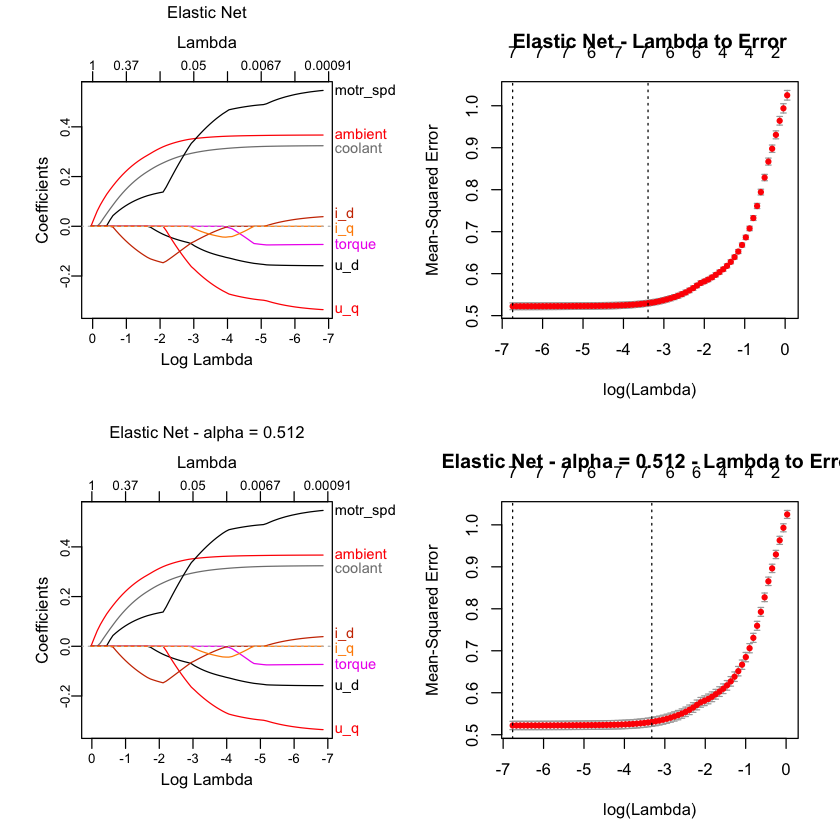

In [61]:
par(mfrow = c(2,2))

plot_glmnet(elastic.net, main = 'Elastic Net')
plot(elastic.net.cv, main = 'Elastic Net - Lambda to Error')
plot_glmnet(elastic.net.alpha, main = paste('Elastic Net - alpha =',best_alpha))
plot(elastic.net.alpha.cv, main = paste('Elastic Net - alpha =',best_alpha,'- Lambda to Error'))

The feature selection of the elastic net model with two different $\alpha$ seem very similar. Both models return `u_q`, `u_d`, `i_d`, `motor_speed`, `ambient`, and `coolant` as the most relevent features for predicting `pm`. Two elastic net models added one more feature `i_d` into the model in comparison to the lasso regression model. The expected test error of the elastic net with $\alpha = 0.5$, on the other hand, shows a better result that the other elastic net model with the $\alpha$ of 0.729. In fact, when comparing shrinkage models with different $\alpha$s, the elastic net model seem to perform the best in comparison to the rest. 

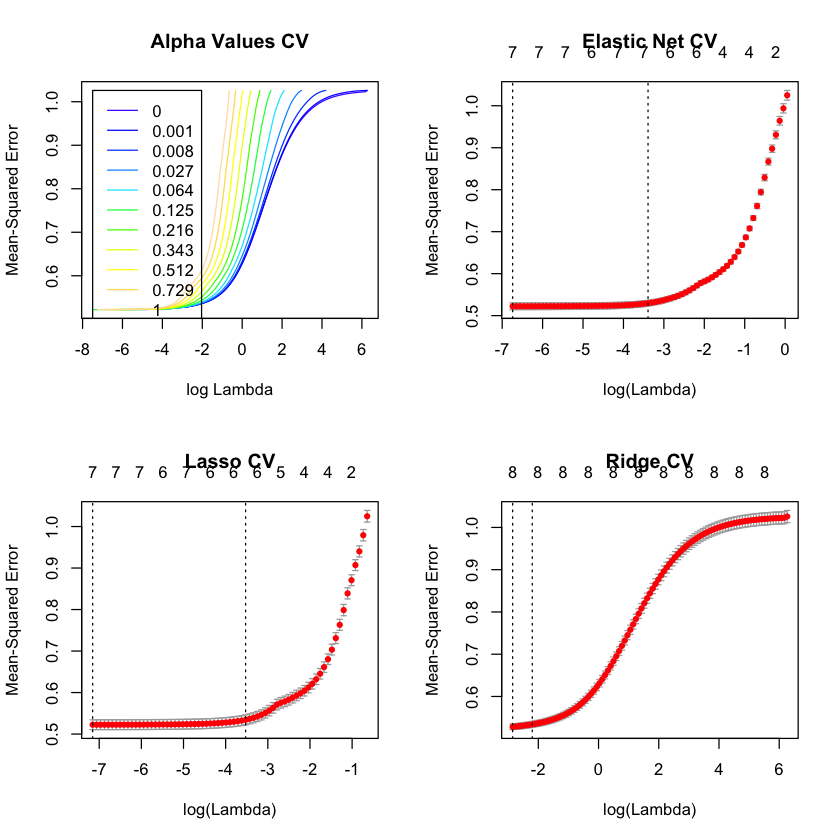

In [62]:
par(mfrow = c(2,2))
plot(cva, main = 'Alpha Values CV')
plot(elastic.net.cv, main = 'Elastic Net CV')
plot(lasso.cv, main = 'Lasso CV')
plot(ridge.cv, main = 'Ridge CV')

In [63]:
folds <- createFolds(train$pm, k = 10, list = TRUE, returnTrain = FALSE)
# partition the data into 5 folds 
k.folds.rmse <- c()
k.folds.rsquared <- c()


alphas <- c(0, 0.5, best_alpha, 1)
# ridge, elastic net with alpha = 0.5, best alpha, lasso
lambdas <- c(ridge.cv$lambda.1se, 
            elastic.net.cv$lambda.1se,
            elastic.net.alpha.cv$lambda.1se,
            lasso.cv$lambda.1se)
# relative lambdas from cross validation 

train.rmse <- c()
train.rsquared <- c()
    
for (i in 1:length(alphas)){
    # looping through each alpha-lambda pairs 
    
    alpha.i <- alphas[i]
    lambda.i <- lambdas[i]
    # call the alpha-lambda pair 
    
    each.param.rmse <- c()
    each.param.rsq <- c()
    # store regression metrics of each hyperparameter pair
    
    for (fold in folds){

    testing <- train[fold,]
    training <- train[-fold,]
    # creating train-test sets of each fold
    
    feature.matrix <- model.matrix(pm~., data = training)[, -1]
    testing.matrix <- model.matrix(pm~., data = testing)[,-1]
    # converting the train and test data set of each fold into a matrix 
        
    fit <- glmnet(feature.matrix, training$pm, family = 'gaussian', alpha = alpha.i)
    predi <- predict(fit, s = lambda.i, newx = testing.matrix)
    # fit the model with the alpha-lambda pair into each train set, predict the result 
        
    r_2 <- rsq(rmse = mean((predi - testing$pm)^2), trainset = testing)
    # calculate the r_2 metric of each fold
    each.param.rmse <- c(each.param.rmse, mean((predi - testing$pm)^2))
    # calculate the rmse metric of each fold
    each.param.rsq <- c(each.param.rsq, r_2)
    }
    
    k.folds.rmse <- c(k.folds.rmse, mean(each.param.rmse))
    k.folds.rsquared <- c(k.folds.rsquared, mean(each.param.rsq))
    # validation metrics is the mean of metrics from all folds 
    
    train.fit <- glmnet(model.matrix(pm~., data = train)[,-1], 
                        train$pm, family = 'gaussian', alpha = alpha.i)
    train.pred <- predict(train.fit, s = lambda.i, 
                          newx = model.matrix(pm~., data = train)[,-1])
    
    r_2 <- rsq(rmse = mean((train.pred - train$pm)^2))
    train.rmse <- c(train.rmse, mean((train.pred - train$pm)^2))
    train.rsquared <- c(train.rsquared, r_2)
    # calculating training metrics 
    
    } 

In [64]:
model <- c('ridge', 'elastic net', 'elastic net best alpha', 'lasso')
metrics <- data.frame(model,k.folds.rmse, k.folds.rsquared, train.rmse, train.rsquared)

In [65]:
metrics

model                  k.folds.rmse k.folds.rsquared train.rmse
1 ridge                  0.5336639    0.4788670        0.5330093 
2 elastic net            0.5295227    0.4828600        0.5287875 
3 elastic net best alpha 0.5306593    0.4817551        0.5299267 
4 lasso                  0.5342459    0.4782545        0.5334785 
  train.rsquared
1 0.4803174     
2 0.4844336     
3 0.4833230     
4 0.4798599

To further confirm this statement, I performed a k-folds cross validation on all four shrinkage models and obtained the validation $R^2$ & RMSE, as well as train $R^2$ & RMSE. Based on the data frame that summarised the metrics of each model above, we can confirm once again that lasso model shows the best predictive performance with the lowest RMSE. Despite its least number of features, training and validation $R^2$ is also the highest amongst all four models. 

## 4. Results and discussion <a class="anchor" id="sec_6"></a>

So far, we have developed 10 different models: 

* KNN
* Random Forest Regression 
* Multiple Regression 
* Polynomial Regression 
* Hybrid Stepwise Regression with AIC
* Hybrid Stepwise Regression with BIC 
* Ridge Regression 
* Lasso Regession 
* Elastic Net Regression with $\alpha = 0.5$ 
* Elastic Net Regression with $\alpha = 0.729$

The validation results by 10-fold cross validation and the training metrics of all the models are as below: 

In [66]:
library(tidyverse)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ purrr   0.3.2       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate()    masks foreach::accumulate()
✖ dplyr::combine()       masks randomForest::combine()
✖ tidyr::expand()        masks Matrix::expand()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::lift()          masks caret::lift()
✖ randomForest::margin() masks ggplot2::margin()
✖ purrr::when()          masks foreach::when()


In [67]:
results <- bind_rows(knn.cv.result, rf.cv.result,
         mr.cv.result, poly.cv.result, ic.cv.result,
         metrics)[c('model','k.folds.rmse', 'k.folds.rsquared', 'train.rmse', 'train.rsquared')]
results[order(results$k.folds.rmse),]

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

model                  k.folds.rmse k.folds.rsquared train.rmse
2  random forest          0.1179757    0.8849740        0.1167160 
1  knn                    0.5005478    0.7566420        0.1522295 
6  AIC                    0.5186478    0.7376638        0.2675498 
4  polynomial regression  0.5189526    0.7374182        0.2674655 
5  BIC                    0.5193552    0.7368111        0.2678161 
8  elastic net            0.5295227    0.4828600        0.5287875 
9  elastic net best alpha 0.5306593    0.4817551        0.5299267 
7  ridge                  0.5336639    0.4788670        0.5330093 
10 lasso                  0.5342459    0.4782545        0.5334785 
3  multiple regression    0.7224551    0.4914876        0.5214238 
   train.rsquared
2  0.8862022     
1  0.8515766     
6  0.7391396     
4  0.7392218     
5  0.7388800     
8  0.4844336     
9  0.4833230     
7  0.4803174     
10 0.4798599     
3  0.4916132

Based on these values, the random forest is expected to perform the best at predicting electric rotor temperature, with the lowest valid RMSE and the highest $R^2$. The non-parametric models are outperforming the parametric models when solely looking at the metrics from cross validation. However, both models have tendency to overfit: the training RMSE and $R^2$ are far better than the validation metrics. Additionally, the random forest model is an ensemble method where the best model is selected from randomly generated decision tree regressions with certain hyperparameters. This means that the model changes whenever we fit the same data again. Therefore, the validation result might not hold for testing process. The worst-performing model is the multiple regression after manually removing `i_q` from the candidate predictors. 

In [68]:
dim(test)
# test model has 5495 observations and 9 columns

[1] 5495    9

In [69]:
# predict the target using test set 
rf.predict <- predict(rf, test)
knn.predict <- knnregTrain(train, test, y=train$pm, k = 5, use.all = TRUE)
poly.predict <- predict(poly.regression, test)
mr.predict <- predict(multiple.regression, test)
bic.predict <- predict(step.bic, test)
aic.predict <- predict(step.aic, test)

Warning message in predict.lm(poly.regression, test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(step.bic, test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(step.aic, test):
“prediction from a rank-deficient fit may be misleading”

In [70]:
model<- c('elastic.net.best.alpha', 'elastic.net','ridge','lasso')
# predict the target using the test set 
for (i in 1:length(alphas)){
    
    alpha.i <- alphas[i]
    lambda.i <- lambdas[i]
    
    feature.matrix <- model.matrix(pm~., data = train)[, -1]
    testing.matrix <- model.matrix(pm~., data = test)[, -1]
        
    fit <- glmnet(feature.matrix, train$pm, family = 'gaussian', alpha = alpha.i)
    predi <- predict(fit, s = lambda.i, newx = testing.matrix)
    
    assign(paste0(model[i],'.predict'),
          predict(fit, s = lambda.i, newx = testing.matrix))}

In [71]:
rmse <- function(predict, truth = test$pm){
    sum((predict-truth)^2)/nrow(test)
}

In [72]:
# calculating the test rmse of each model's result using the function rmse built above 
rmses <- c(rmse(knn.predict),
 rmse(rf.predict),
 rmse(mr.predict),
 rmse(poly.predict),
 rmse(bic.predict),
 rmse(aic.predict),
 rmse(ridge.predict),
 rmse(elastic.net.predict),
 rmse(elastic.net.best.alpha.predict),
 rmse(lasso.predict))
# use mapply - rsq function to calculate Rsquared of all the models 
r_2 <- mapply(rsq, rmses)

In [73]:
test.result <- data.frame(model = results$model, test.rmses = rmses, test.rSquared = r_2)
result.comparison <- merge(x = test.result, y = results)
result.comparison[order(result.comparison$test.rmses),]

model                  test.rmses test.rSquared k.folds.rmse
5  knn                    0.03210169 0.9687009     0.5005478   
2  BIC                    0.37775587 0.6316891     0.5193552   
8  polynomial regression  0.37961799 0.6298735     0.5189526   
1  AIC                    0.37964533 0.6298469     0.5186478   
4  elastic net best alpha 0.47785002 0.5340976     0.5306593   
6  lasso                  0.47878342 0.5331875     0.5342459   
10 ridge                  0.48105151 0.5309761     0.5336639   
3  elastic net            0.48222349 0.5298334     0.5295227   
7  multiple regression    0.50355449 0.5090358     0.7224551   
9  random forest          0.66681330 0.3498589     0.1179757   
   k.folds.rsquared train.rmse train.rsquared
5  0.7566420        0.1522295  0.8515766     
2  0.7368111        0.2678161  0.7388800     
8  0.7374182        0.2674655  0.7392218     
1  0.7376638        0.2675498  0.7391396     
4  0.4817551        0.5299267  0.4833230     
6  0.4782545        0.5334785  0.4798599     
10 0.4788670        0.5330093  0.4803174     
3  0.4828600        0.5287875  0.4844336     
7  0.4914876        0.5214238  0.4916132     
9  0.8849740        0.1167160  0.8862022

Contrary to the result from validation metrics, KNN regression model has outperformed every single model. The huge difference between the validation and the test result of this model could be due to the validation method I have used: For 10-fold validation that I have used for KNN model, each fold had roughly a little more than 900 data points. Since KNN has more tendency to overfit to the train set with smaller data set, the model did not perform well for validation folds with small sample sizes. This might have resulted in low performance in validation process, but opposite in the training data set. The test data set, on the other hand, had more than 5000 data points. The sample size of the test data set might have been sufficiently large enough to fit the KNN model. 


Random forst model, which had the best validation RMSE and $R^2$, performed the worst in comparison to any other models. This is a very surprising result since the esimtated test error (`k.folds.rmse`) was far lower than any other models. One assumption under this is that the validation error of the random forest model was returned by OOB error, which could yield a different result if I cross validated the random forest model. Another possible assumption is that the depth of the decision trees was not specified before training the model. When tuning the hyperparameters of the random forest model, I did not look for the optimised depth of the decision tree in the random forest model. This could have led to a very deep decision tree with lots of nodes and splits. Especially considering that the `mtry` parameter was equal to the number of features available, it could've been possible that unpruned deep decision trees were presented in the bag. A visualisation of the random forest model or inspection of the tree structure could have been helpful to avoid this issue. Especially the fact that I did not perform a k-fold cross validation but solely used OOB error as the validation metric could have led to this contrary test result. 

The polynomial regression model and its subset selection models performed also very well. Especially the stepwise regression model with BIC penalty performed the best in comparison to other two polynomial regression models. This also contradicts the results from k-fold cross validation I had, where BIC model had the worst validation metrics in comparison to AIC and polynomial regression. This could have resulted due to the less number of parameters of BIC, which enhanced its generalisation capability, and thus performed better on unseen data set than the other two. In fact, the AIC and polynomial regression model yielded the identical test RMSE and $R^2$. In this case, AIC is still a better model than the polynomial regression model due to its slightly lower complexity. 

When I performed 10-folds cross validation to all the models with shrinkage methods, all of them performed significantly better than the multiple regression model. In fact, the multiple regression model after removing `i_q` was the worst model out of the 10. However, the test results show that all models with shrinkage method have almost similar performance as the simple regression model. Only the elastic net model with the tuned $\alpha$ performed slightly better. This suggests that manually removing features using cross validation yields exactly the same result shrinkage methods. Considering that polynomial regression with interaction variable outperformed all the models with shrinkage methods, I assume that performing shrinkage methods on polynomial regression models could have yield a completely better result.

## 5. Conclusion<a class="anchor" id="sec_7"></a>

This program was aimed to create models using various features in order to predict the electric rotor temperature. To select apt model for prediction, the program conducted extensive exploratory data analysis in order to understand and visualise the statistical characteristics of each attribute, as well as their relationships. With the result from the EDA, 2 non-parametric models and 8 parametric regression models were selected for predicting the target variable. Cross validation was applied to all models in order to tune the hyperparameters and estimate their performance with unseen data sets. The shortcomings and advantages of each model were also discussed during the model fitting and development process. Finally, the test data set were applied to all the fine-tuned models for the target prediction. The testing results suggest that KNN and polynomial regression models performed the best, while random forest showed the worst prediction performance. This contradicted the results from validation process, and the possible assumption behind such contradictions were also given. 

## 6. References <a class="anchor" id="sec_8"></a>

createDataPartition function - RDocumentation. (n.d.). R Documentation. https://www.rdocumentation.org/packages/caret/versions/6.0-86/topics/createDataPartition

ggplot2 : Quick correlation matrix heatmap - R software and data visualization - Easy Guides - Wiki - STHDA. (n.d.). STHDA. http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization

KNN and K-folding in R. (2017, December 15). Cross Validated. https://stats.stackexchange.com/questions/318968/knn-and-k-folding-in-r

knnreg function - RDocumentation. (n.d.). RDocumentation. https://www.rdocumentation.org/packages/caret/versions/6.0-86/topics/knnreg

Random Forests · UC Business Analytics R Programming Guide. (n.d.). UC Business Analytics R Programming Guide. Retrieved April 22, 2021, from https://uc-r.github.io/random_forests

R: Do elastic net cross-validation for alpha and lambda. . . (n.d.). R Documentation. http://finzi.psych.upenn.edu/library/glmnetUtils/html/cva.glmnet.html

Scatter Plot Matrices - R Base Graphs - Easy Guides - Wiki - STHDA. (n.d.). STHDA. http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs

Teixeira-Pinto, A. (2020, August 10). 2 K-nearest Neighbours Regression | Machine Learning for Biostatistics. Biostatistics Collaboration of Australia. https://bookdown.org/tpinto_home/Regression-and-Classification/k-nearest-neighbours-regression.html

Zumel, N., & Mount, J. (2019). Practical Data Science with R (2nd ed.) [E-book]. Manning Publications. https://livebook.manning.com/book/practical-data-science-with-r-second-edition/chapter-7/1